# 0. Import Libraries

In [1]:
import os
import pandas as pd
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
benchmark_dir = "/data/tmpA/andrem/benchmark"

# 1. Utils

## 1.1. Utils for overall benchmarking (2)

In [4]:
import re
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

def extract_dataset_id(filename):
    """Extracts AML dataset ID from filename (e.g., AML12_DX)."""
    match = re.search(r'(AML\d+_[A-Z]+)', filename)
    return match.group(1) if match else None

def summarize_grn_performance(benchmark_data, config_pairs, metric_columns=None):
    """
    Summarizes GRN performance and computes pairwise Wilcoxon signed-rank p-values using shared datasets.

    Parameters
    ----------
    benchmark_data : dict
        Nested dictionary of the form {tool: {config: {filename: DataFrame}}}.
    config_pairs : dict
        Mapping from label string → (tool, config).
    metric_columns : list of str or None
        If provided, selects only these metrics for averaging.

    Returns
    -------
    dict with:
        - 'x': list of global averages per configuration
        - 'y': list of configuration labels
        - 'std': list of standard deviations
        - 'avrg_grn': dict mapping label → list of per-GRN average scores
        - 'p-values': dict of pairwise p-values (label1|label2: pval)
    """

    result = {
        'x': [],
        'y': [],
        'std': [],
        'avrg_grn': {},
        'p-values': {}
    }

    # Auxiliary dict to store dataset-wise scores per label
    dataset_scores_by_label = {}

    # Step 1: Compute per-GRN average scores
    for label, (tool, config) in config_pairs.items():
        file_dict = benchmark_data.get(tool, {}).get(config, {})
        grn_scores = []
        dataset_scores = {}

        for fname, df in file_dict.items():
            dataset_id = extract_dataset_id(fname)
            if not dataset_id:
                continue

            if metric_columns is None:
                values = df.select_dtypes(include=[np.number]).values.flatten()
            else:
                values = df[metric_columns].values.flatten()

            values = values[~np.isnan(values)]
            if values.size > 0:
                score = np.mean(values)
                grn_scores.append(score)
                dataset_scores[dataset_id] = score

        result['avrg_grn'][label] = grn_scores
        dataset_scores_by_label[label] = dataset_scores
        result['x'].append(np.mean(grn_scores) if grn_scores else np.nan)
        result['std'].append(np.std(grn_scores) if grn_scores else np.nan)
        result['y'].append(label)

    # Step 2: Compute Wilcoxon signed-rank p-values on shared datasets
    labels = list(config_pairs.keys())
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            l1, l2 = labels[i], labels[j]
            d1, d2 = dataset_scores_by_label[l1], dataset_scores_by_label[l2]
            shared_ids = sorted(set(d1.keys()) & set(d2.keys()))
            if len(shared_ids) < 2:
                print(f"[WARN] Too few shared datasets for {l1} vs {l2}, skipping.")
                continue

            scores1 = [d1[k] for k in shared_ids]
            scores2 = [d2[k] for k in shared_ids]

            try:
                stat, pval = wilcoxon(scores1, scores2)
            except ValueError as e:
                print(f"[WARN] Wilcoxon failed for {l1} vs {l2}: {e}")
                pval = np.nan

            key1 = f"{l1}|{l2}"
            key2 = f"{l2}|{l1}"
            result['p-values'][key1] = pval
            result['p-values'][key2] = pval

    return result


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_grn_violin(
    summary,
    title,
    xlabel,
    ylabel,
    best_color="#1a57e4",
    other_color="#bbbbbb",
    alpha=0.8,
    show_pvalues=True,
    xlim=None
):
    """
    Plots horizontal violin plots of GRN scores per configuration with means, stds,
    average value labels, and optional significance annotations.

    Parameters
    ----------
    summary : dict
        Output of summarize_grn_performance().
    best_color : str
        Color for the best (top-scoring) configuration.
    other_color : str
        Color for all other configurations.
    alpha : float
        Transparency for the scatter points.
    show_pvalues : bool
        Whether to display significance annotations.
    xlim : list or tuple of float or None
        Optional [xmin, xmax] for x-axis limits. If None, computed automatically.
    """
    x_vals = summary["x"]
    y_labels = summary["y"]
    std_vals = summary["std"]
    avrg_grn = summary["avrg_grn"]
    pvals = summary.get("p-values", {})

    # Determine best-scoring config
    best_idx = int(np.nanargmax(x_vals))
    best_label = y_labels[best_idx]

    # Prepare data
    data = []
    for label in y_labels:
        for score in avrg_grn[label]:
            data.append({"Label": label, "Score": score})
    df_plot = pd.DataFrame(data)

    # Order labels by descending mean (best at top)
    ordered_labels = [lbl for _, lbl in sorted(zip(x_vals, y_labels), reverse=True)]

    # Auto figure height
    fig_height = 0.6 * len(ordered_labels) + 1.5
    plt.figure(figsize=(11.5, fig_height))  # extra width for annotations

    ax = sns.violinplot(
        data=df_plot, y="Label", x="Score",
        order=ordered_labels,
        palette=[best_color if lbl == best_label else other_color for lbl in ordered_labels],
        inner=None, cut=0
    )

    # Get y-axis label positions
    y_positions = {label: y for y, label in enumerate(ordered_labels)}

    # Plot GRN points (jittered)
    for label in ordered_labels:
        scores = avrg_grn[label]
        y = y_positions[label]
        y_jitter = np.random.normal(loc=y, scale=0.08, size=len(scores))
        plt.scatter(scores, y_jitter, alpha=alpha, color="black", s=15, zorder=3)

    # Plot mean (red dot) + std (black errorbar)
    for label, mu, std in zip(y_labels, x_vals, std_vals):
        if label not in y_positions or np.isnan(mu):
            continue
        y = y_positions[label]
        plt.plot(mu, y, 'o', color='#cc4c4c', markersize=6, zorder=5)
        plt.errorbar(mu, y, xerr=std, fmt='none', ecolor='black', capsize=3, zorder=4)

    # Add significance markers outside the plot box (if enabled)
    if show_pvalues:
        for label in ordered_labels:
            if label == best_label:
                continue
            p = pvals.get(f"{best_label}|{label}", np.nan)
            if np.isnan(p): continue

            if p < 0.001:
                sig = "***"
            elif p < 0.01:
                sig = "**"
            elif p < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            y = y_positions[label]
            ax.text(1.015, y, sig, transform=ax.get_yaxis_transform(),
                    ha='left', va='center', fontsize=12, color='black')

    # Set x-limits
    if xlim is not None and isinstance(xlim, (list, tuple)) and len(xlim) == 2:
        ax.set_xlim(xlim)
    else:
        x_all = [score for scores in avrg_grn.values() for score in scores]
        x_max_plot = max(x_all + x_vals)
        ax.set_xlim(np.min(x_all) - 0.02, x_max_plot + 0.05)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=10)
    plt.grid(True, axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [6]:
import numpy as np

def prepare_heatmap_data(summary):
    """
    Transforms summary['x'] and summary['y'] into a matrix, x_labels, and y_labels
    suitable for heatmap visualization.

    Parameters:
        summary (dict): Contains 'x' (values) and 'y' (<dataset>:<tool+config> labels)

    Returns:
        values (list of list): Matrix of values [rows: datasets, cols: tools+configs]
        x_labels (list): Tool+config labels (columns)
        y_labels (list): Dataset labels (rows)
    """
    assert len(summary['x']) == len(summary['y']), "Mismatch in x and y length"

    dataset_labels = set()
    toolconfig_labels = set()
    value_map = {}

    for label, val in zip(summary['y'], summary['x']):
        dataset, toolconfig = label.split(":", 1)
        dataset_labels.add(dataset)
        toolconfig_labels.add(toolconfig)
        value_map[(dataset, toolconfig)] = val

    y_labels = sorted(dataset_labels)
    x_labels = sorted(toolconfig_labels)

    # Create index mappings
    y_idx = {y: i for i, y in enumerate(y_labels)}
    x_idx = {x: i for i, x in enumerate(x_labels)}

    # Initialize matrix with NaNs
    matrix = np.full((len(y_labels), len(x_labels)), np.nan)

    # Fill in the matrix
    for (y, x), val in value_map.items():
        matrix[y_idx[y], x_idx[x]] = val

    return matrix.tolist(), x_labels, y_labels


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_heatmap(
    values,
    x_labels,
    y_labels,
    title="Heatmap",
    xlabel="X-axis",
    ylabel="Y-axis",
    colorbar_label="Score",
    figsize=(10, 8),
    cmap="RdBu",
    fmt=".2f",
    normalize=False,
    show_na=True,
    sort_y_labels=True,
    sort_x_by_mean=True
):
    """
    Plots a heatmap with:
      - Optional normalization to [0, 1]
      - Custom colorbar label
      - 'n.a.' shown in missing cells
      - X-axis sorted by column-wise average (descending)
      - Y-axis sorted alphabetically
    """
    # Convert to float matrix
    values = np.array(values, dtype=np.float64)

    # Optional: sort y-axis labels alphabetically
    if sort_y_labels:
        y_sorted_idx = np.argsort(y_labels)
        y_labels = [y_labels[i] for i in y_sorted_idx]
        values = values[y_sorted_idx, :]

    # Optional: sort x-axis by column-wise average
    if sort_x_by_mean:
        col_means = np.nanmean(values, axis=0)
        x_sorted_idx = np.argsort(-col_means)  # descending
        x_labels = [x_labels[i] for i in x_sorted_idx]
        values = values[:, x_sorted_idx]
    else:
        x_sorted_idx = np.arange(len(x_labels))

    # Optional: normalize values globally
    if normalize:
        valid_mask = ~np.isnan(values)
        vmin = np.nanmin(values)
        vmax = np.nanmax(values)
        scale = vmax - vmin if vmax != vmin else 1.0
        values[valid_mask] = (values[valid_mask] - vmin) / scale
        
    # Generate annotation matrix (formatted numbers or "n.a.")
    if show_na:
        annotation = np.empty_like(values, dtype=object)
        for i in range(values.shape[0]):
            for j in range(values.shape[1]):
                if np.isnan(values[i, j]):
                    annotation[i, j] = "n.a."
                else:
                    annotation[i, j] = format(values[i, j], fmt)
    else:
        annotation = None  # use default seaborn behavior

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        values,
        xticklabels=x_labels,
        yticklabels=y_labels,
        cmap=cmap,
        annot=annotation,
        fmt="",
        cbar=True,
        vmin=0.0 if normalize else None,
        vmax=1.0 if normalize else None,
        center=0.5 if normalize else None
    )

    # Labels and layout
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=0, ha='center')
    plt.yticks(rotation=0)

    # Colorbar label
    cbar = ax.collections[0].colorbar
    cbar.set_label(colorbar_label, fontsize=12)

    plt.tight_layout()
    plt.show()


In [8]:
def scenicplus_config_parser_pseudo(filename):
    if "metacell_0" in filename:
        match = re.search(r'_MO_([^_]+)_', filename)
        if match:
            return match.group(1)
        else:
            raise ValueError(f"MO not found in filename: {filename}")
    else:
        match = re.search(r'_metacell_(\d+)_', filename)
        if match:
            return f"pseudobulk:{match.group(1)}"
        else:
            raise ValueError(f"Metacell not found in filename: {filename}")

def celloracle_config_parser(filename):
    if "MO" in filename:
        match = re.search(r'_MO_([^_]+)_', filename)
        if match:
            return match.group(1)
        else:
            raise ValueError(f"MO not found in filename: {filename}")
    elif "without" in filename:
        return "without_atac"
    else:
        return "with_atac"

def linger_config_parser(filename):
    if "MO" in filename:
        match = re.search(r'_MO_([^_]+)_', filename)
        if match:
            return match.group(1)
        else:
            raise ValueError(f"MO not found in filename: {filename}")
    else:
        raise ValueError(f"MO not found in filename: {filename}")

In [9]:
import os
import pandas as pd

def load_benchmark_data(grn_tools, benchmark_dir, config_parsers):
    """
    Load benchmark result files into a nested dictionary:
    {tool: {config: {filename: DataFrame}}}
    
    Parameters:
        grn_tools (list): List of tool names to load.
        benchmark_dir (str): Base directory containing tool folders.
        config_parsers (dict): Mapping of tool → config parser function.
        
    Returns:
        dict: Nested benchmark data.
    """
    benchmark_data = {}

    for tool in grn_tools:
        tool_dir = os.path.join(benchmark_dir, tool)
        if not os.path.isdir(tool_dir):
            raise FileNotFoundError(f"Directory not found for tool: {tool}")

        config_parser = config_parsers.get(tool, lambda f: "default")
        tool_configs = {}

        for filename in os.listdir(tool_dir):
            if not filename.endswith("results.csv"):
                continue

            file_path = os.path.join(tool_dir, filename)
            try:
                config = config_parser(filename)
            except Exception as e:
                print(f"[WARN] Skipping {filename} for {tool}: {e}")
                continue

            df = pd.read_csv(file_path, sep="\t")

            if config not in tool_configs:
                tool_configs[config] = {}
            tool_configs[config][filename] = df

        benchmark_data[tool] = tool_configs

    return benchmark_data


## 1.2. Utils for benchmarking dataset focused

In [10]:
import os
import pandas as pd

def load_benchmark_data_with_parser(grn_tools, benchmark_dir, config_parsers, dataset_parser):
    """
    Load benchmark result files into a nested dictionary:
    {dataset: {tool: {filename: DataFrame}}}
    
    Parameters:
        grn_tools (list): List of tool names to load.
        benchmark_dir (str): Base directory containing tool folders.
        config_parsers (dict): Mapping of tool → config parser function.
        dataset_parser (function): Function to extract dataset name from filename.
        
    Returns:
        dict: Nested benchmark data.
    """
    benchmark_data = {}

    for tool in grn_tools:
        tool_dir = os.path.join(benchmark_dir, tool)
        if not os.path.isdir(tool_dir):
            raise FileNotFoundError(f"Directory not found for tool: {tool}")

        # Still parse config for side effects/logging, but no longer use it as key
        config_parser = config_parsers.get(tool, lambda f: "default")

        for filename in os.listdir(tool_dir):
            if not filename.endswith("results.csv"):
                continue

            file_path = os.path.join(tool_dir, filename)

            try:
                _ = config_parser(filename)  # parsed but not used
                dataset = dataset_parser(filename)
            except Exception as e:
                print(f"[WARN] Skipping {filename} for {tool}: {e}")
                continue

            df = pd.read_csv(file_path, sep="\t")

            if dataset not in benchmark_data:
                benchmark_data[dataset] = {}
            if tool not in benchmark_data[dataset]:
                benchmark_data[dataset][tool] = {}

            benchmark_data[dataset][tool][filename] = df

    return benchmark_data


In [11]:
def dataset_parser(filename):
    """
    Extract the dataset name from a filename.
    
    - If filename contains '_MO_', extract everything up to and including the tool name (third token).
      Example: AML15_REL_MO_scdart_* → AML15_REL_MO_scdart
    - Otherwise, return the first two tokens (sample and condition).
      Example: AML15_REL_scdart_* → AML15_REL
    """
    parts = filename.split("_")
    
    if "MO" in parts:
        mo_index = parts.index("MO")
        if mo_index + 1 < len(parts):
            return "_".join(parts[:mo_index + 2])  # e.g., AML15_REL_MO_scdart
        else:
            raise ValueError(f"Could not find tool name after 'MO' in filename: {filename}")
    else:
        return "_".join(parts[:2])  # e.g., AML15_REL

def scenicplus_config_parser(filename):
    if "metacell_0" in filename:
        match = re.search(r'_MO_([^_]+)_', filename)
        if match:
            return match.group(1)
        else:
            raise ValueError(f"MO not found in filename: {filename}")
    else:
        match = re.search(r'_metacell_(\d+)_', filename)
        if match:
            return f"pseudobulk"
        else:
            raise ValueError(f"Metacell not found in filename: {filename}")


In [12]:
import os
import pickle
import anndata as ad

def get_rna_stats(file_path):
    adata = ad.read_h5ad(file_path)
    return {
        "n_rna_cells": adata.n_obs,
        "n_genes": adata.n_vars
    }

def get_atac_stats(file_path):
    with open(file_path, "rb") as f:
        cistopic_obj = pickle.load(f)
    fragments = cistopic_obj.fragment_matrix
    return {
        "n_atac_cells": fragments.shape[1],
        "n_fragments": fragments.shape[0]
    }

def save_group_to_csv(group_dict, output_dir, filename):
    df = pd.DataFrame.from_dict(group_dict, orient="index")
    df.index.name = "dataset"
    df = df.reset_index().sort_values("dataset")

    # Ensure n_total_cells is last
    cols = [col for col in df.columns if col != "n_total_cells"]
    if "n_total_cells" in df.columns:
        cols.append("n_total_cells")
    df = df[cols]

    # Convert all numeric columns to integers (nullable Int64 to handle NaNs)
    for col in df.columns:
        if col != "dataset":
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    df.to_csv(os.path.join(output_dir, filename), index=False)

In [13]:
from tabulate import tabulate

def preview_group(group_dict, title):
    df = pd.DataFrame.from_dict(group_dict, orient="index")
    df.index.name = "dataset"
    df = df.reset_index().sort_values("dataset")
    
    # Reorder and convert to Int64
    cols = [col for col in df.columns if col != "n_total_cells"]
    if "n_total_cells" in df.columns:
        cols.append("n_total_cells")
    df = df[cols]
    for col in df.columns:
        if col != "dataset":
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    print(f"\n{title}")
    print(tabulate(df, headers="keys", tablefmt="github", showindex=False))


In [14]:
def merge_tools_by_dataset(nested_data, include_tools=None):
    """
    Flattens a nested dictionary from:
        {dataset: {tool: {filename: DataFrame}}}
    into:
        {dataset: {filename_with_tool: DataFrame}}
    where filenames are disambiguated by appending the tool name before '.csv'.

    Parameters:
        nested_data (dict): Original nested data.
        include_tools (list or None): If provided, only include files from these tools.

    Returns:
        dict: Flattened dataset-wise data.
    """
    merged = {}

    for dataset, tool_dict in nested_data.items():
        merged[dataset] = {}

        for tool, file_dict in tool_dict.items():
            if include_tools is not None and tool not in include_tools:
                continue  # Skip this tool

            for fname, df in file_dict.items():
                if fname.endswith(".csv"):
                    fname_new = fname.replace(".csv", f"_{tool}.csv")
                else:
                    fname_new = f"{fname}_{tool}"

                if fname_new in merged[dataset]:
                    print(f"[WARN] Overwriting {fname_new} in {dataset} (already exists)")

                merged[dataset][fname_new] = df

    return merged


In [15]:
import numpy as np
import pandas as pd

def summarize_dataset_averages(data_dict, metric=None):
    """
    Computes per-dataset averages over file-level means.

    Parameters:
        data_dict: dict of {dataset: {filename: DataFrame}}
        metric: optional str. If provided, averages only that column. Else all numeric values.

    Returns:
        dict with:
            - 'x': list of per-dataset means
            - 'y': list of dataset names
            - 'std': list of per-dataset std deviations
            - 'avrg_grn': dataset → list of file-level means
    """
    result = {
        'x': [],
        'y': [],
        'std': [],
        'avrg_grn': {}
    }

    for dataset, file_dict in data_dict.items():
        file_means = []

        for fname, df in file_dict.items():
 
            df.columns = df.columns.str.strip()

            if metric is None:
                values = df.select_dtypes(include=[np.number]).values.flatten()
            else:
                if metric not in df.columns:
                    print(f"[WARN] {metric} not in {fname}, skipping")
                    continue
                values = df[metric].values.flatten()

            values = values[~np.isnan(values)]
            if values.size > 0:
                file_means.append(np.mean(values))
            else:
                print(f"[WARN] No valid numeric values in {fname}, skipping")

        result['y'].append(dataset)
        result['x'].append(np.mean(file_means) if file_means else np.nan)
        result['std'].append(np.std(file_means) if file_means else np.nan)
        result['avrg_grn'][dataset] = file_means

    return result


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_regression(
    x, y, std=None,
    xlabel="n_total_cells",
    ylabel="Average F0.1 Score",
    title="Correlation Plot",
    show_std=False
):
    """
    Plots a stylized scatterplot with optional std error bars, a solid regression line, and R².

    Parameters:
        x (list or array): Independent variable values.
        y (list or array): Dependent variable values.
        std (list or array, optional): Y-axis standard deviations.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        title (str): Plot title.
        show_std (bool): Whether to show std as error bars.
    """
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    # Remove NaNs
    mask = ~np.isnan(x.flatten()) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    if std is not None:
        std = np.array(std)[mask]
    else:
        std = np.zeros_like(y)

    # Fit regression
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)

    # Style
    plt.figure(figsize=(9, 6))
    plt.style.use('seaborn-colorblind')# softer color palette

    # Scatter and error bars
    if show_std:
        plt.errorbar(
            x.flatten(), y, yerr=std,
            fmt='o', markersize=7, capsize=4,
            markerfacecolor='steelblue', markeredgecolor='black',
            ecolor='gray', alpha=0.9, label='Data'
        )
    else:
        plt.scatter(
            x.flatten(), y,
            s=70, edgecolor='black',
            facecolor='steelblue', alpha=0.85, label='Data'
        )

    # Regression line
    sorted_idx = np.argsort(x.flatten())
    plt.plot(
        x.flatten()[sorted_idx], y_pred[sorted_idx],
        linestyle='-', linewidth=2.5, color='#e41a1c',
        label=f"Linear Fit (R² = {r2:.3f})"
    )

    # Aesthetic adjustments
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, pad=10)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.box(False)
    plt.show()


In [17]:
import pandas as pd
from pathlib import Path
import numpy as np

def load_sizes_from_csvs(csv_paths):
    """
    Load RNA/ATAC summary statistics from multiple CSV files into a nested dictionary.
    NaNs are safely replaced with 0.

    Parameters
    ----------
    csv_paths : list of str or Path
        Paths to the summary CSV files.

    Returns
    -------
    dict
        Nested dictionary in the format:
        {
            dataset_name: {
                "n_total_cells": int,
                "n_genes": int,
                "n_fragments": int
            },
            ...
        }
    """
    sizes = {}

    for path in csv_paths:
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            dataset = row["dataset"]
            stats = {
                "n_total_cells": int(row["n_total_cells"]) if not pd.isna(row["n_total_cells"]) else 0,
                "n_genes": int(row["n_genes"]) if not pd.isna(row["n_genes"]) else 0,
                "n_fragments": int(row["n_fragments"]) if not pd.isna(row["n_fragments"]) else 0,
            }
            sizes[dataset] = stats

    return sizes


# 2. Benchmark GRNs and their configurations

## 2.1. Load data

In [18]:
grn_tools = ["scenicplus", "celloracle", "linger"]

config_parsers = {
    "scenicplus": scenicplus_config_parser_pseudo,
    "celloracle": celloracle_config_parser,
    "linger": linger_config_parser,
}

benchmark_data = load_benchmark_data(grn_tools, benchmark_dir, config_parsers)


## 2.2 Benchmark GRN tools different configurations

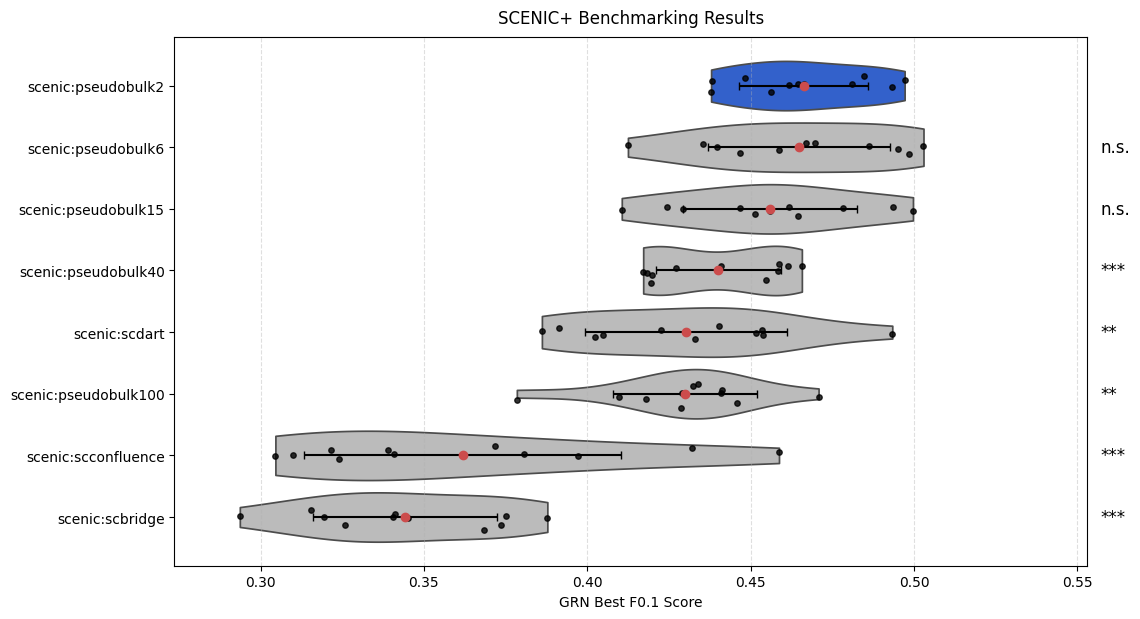

In [23]:
config_pairs = {
    "scenic:pseudobulk2": ("scenicplus", "pseudobulk:2"),
    "scenic:pseudobulk6": ("scenicplus", "pseudobulk:6"),
    "scenic:pseudobulk15": ("scenicplus", "pseudobulk:15"),
    "scenic:pseudobulk40": ("scenicplus", "pseudobulk:40"),
    "scenic:pseudobulk100": ("scenicplus", "pseudobulk:100"),
    "scenic:scdart": ("scenicplus", "scdart"),
    "scenic:scbridge": ("scenicplus", "scbridge"),
    "scenic:scconfluence": ("scenicplus", "scconfluence")
}

summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_fbeta"])

title = "SCENIC+ Benchmarking Results"
xlabel = "GRN Best F0.1 Score"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel)

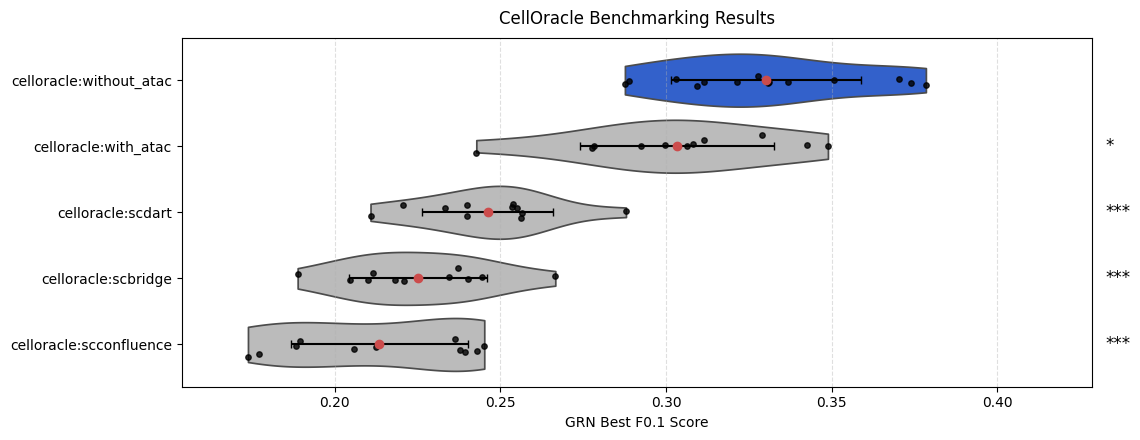

In [24]:
config_pairs = {
    "celloracle:with_atac": ("celloracle", "with_atac"),
    "celloracle:without_atac": ("celloracle", "without_atac"),
    "celloracle:scbridge": ("celloracle", "scbridge"),
    "celloracle:scdart": ("celloracle", "scdart"),
    "celloracle:scconfluence": ("celloracle", "scconfluence")
}
summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_fbeta"])

title = "CellOracle Benchmarking Results"
xlabel = "GRN Best F0.1 Score"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel)

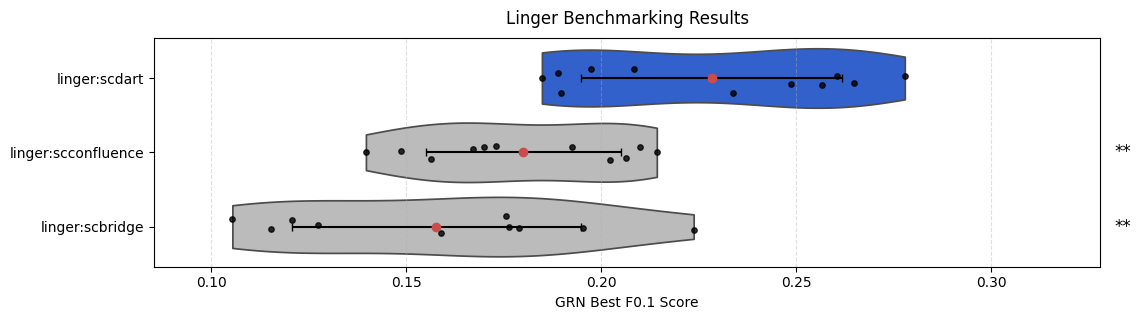

In [21]:
config_pairs = {
    "linger:scdart": ("linger", "scdart"),
    "linger:scbridge": ("linger", "scbridge"),
    "linger:scconfluence": ("linger", "scconfluence"),
}
summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_fbeta"])

title = "Linger Benchmarking Results"
xlabel = "GRN Best F0.1 Score"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel)

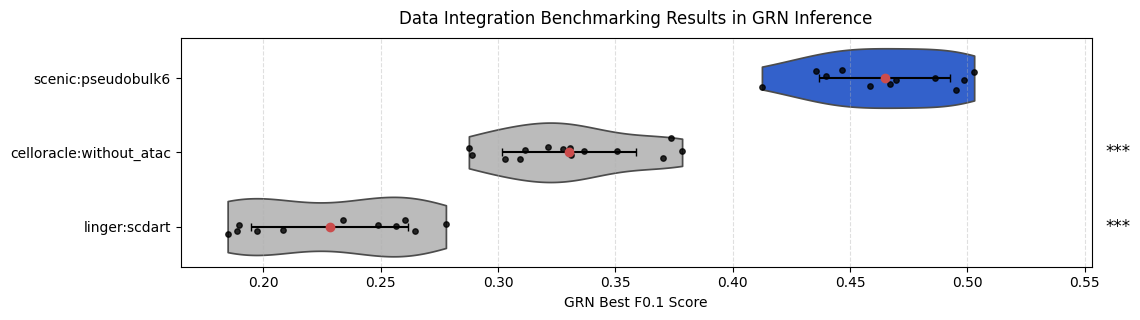

In [22]:
config_pairs = {
    "scenic:pseudobulk6": ("scenicplus", "pseudobulk:6"),
    "celloracle:without_atac": ("celloracle", "without_atac"),
    "linger:scdart": ("linger", "scdart")
    }

summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_fbeta"])

title = "Data Integration Benchmarking Results in GRN Inference"
xlabel = "GRN Best F0.1 Score"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel)


# 3. Dataset focused benchmark

## 3.1. Load Data

In [28]:
grn_tools = ["scenicplus", "celloracle", "linger"]

config_parsers = {
    "scenicplus": scenicplus_config_parser,
    "celloracle": celloracle_config_parser,
    "linger": linger_config_parser,
}

benchmark_data = load_benchmark_data_with_parser(grn_tools, benchmark_dir, config_parsers, dataset_parser)


## 3.2. Benchmarking per Dataset

In [29]:
config_pairs = {}

for dataset in benchmark_data.keys():
    for tool_config in benchmark_data[dataset].keys():
        config_pairs[dataset+':'+tool_config] = (dataset, tool_config)

summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_fbeta"])


[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML15_REL_MO_scdart:celloracle, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML15_REL_MO_scdart:linger, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML15_DX:scenicplus, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML15_DX:celloracle, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML15_REM:scenicplus, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML15_REM:celloracle, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML12_DX:scenicplus, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML12_DX:celloracle, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs AML13_DX_MO_scbridge:scenicplus, skipping.
[WARN] Too few shared datasets for AML15_REL_MO_scdart:scenicplus vs

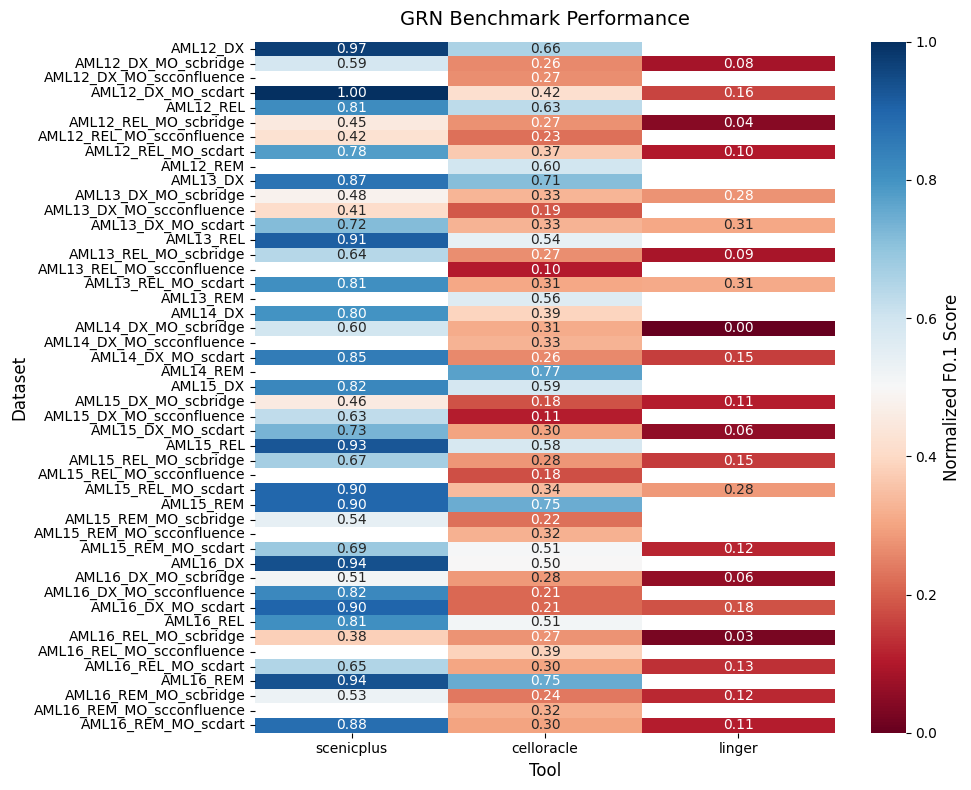

In [30]:
values, x_labels, y_labels = prepare_heatmap_data(summary)

plot_heatmap(
    values=values,
    x_labels=x_labels,
    y_labels=y_labels,
    title="GRN Benchmark Performance",
    xlabel="Tool",
    ylabel="Dataset",
    colorbar_label="Normalized F0.1 Score",
    normalize=True
)


## 3.3. Dataset Size and Score

### 3.3.1. Get sizes

In [ ]:
# This was to create the CSV files for RNA and ATAC stats 

# import os
# import pandas as pd

# rna_input_dir = "../../data/input/input_rna"
# atac_input_dir = "../../data/output/pycistopic-obj/without-model"

# # Output directory
# output_dir = "../../results"
# os.makedirs(output_dir, exist_ok=True)

# sizes = {}

# # Load RNA files
# for fname in os.listdir(rna_input_dir):
#     if not fname.endswith(".h5ad"):
#         continue
#     dataset = dataset_parser(fname)
#     full_path = os.path.join(rna_input_dir, fname)
#     sizes.setdefault(dataset, {})
#     sizes[dataset].update(get_rna_stats(full_path))

# # Load ATAC files
# for fname in os.listdir(atac_input_dir):
#     if not fname.endswith(".pkl"):
#         continue
#     dataset = dataset_parser(fname)
#     full_path = os.path.join(atac_input_dir, fname)
#     sizes.setdefault(dataset, {})
#     sizes[dataset].update(get_atac_stats(full_path))

# # Post-process: compute total cells and always keep n_genes and n_fragments
# for dataset, stats in sizes.items():
#     n_genes = stats.get("n_genes")
#     n_fragments = stats.get("n_fragments")

#     if "MO" in dataset:
#         n = stats.get("n_rna_cells") or stats.get("n_atac_cells") or 0
#         sizes[dataset] = {
#             "n_total_cells": n,
#             "n_genes": n_genes,
#             "n_fragments": n_fragments
#         }
#     else:
#         x = stats.get("n_rna_cells", 0)
#         y = stats.get("n_atac_cells", 0)
#         sizes[dataset]["n_total_cells"] = x + y

# # Group datasets
# no_mo = {}
# mo_scdart = {}
# mo_scbridge = {}
# mo_scconfluence = {}

# for dataset, stats in summary.items():
#     if "MO" not in dataset:
#         no_mo[dataset] = stats
#     elif "scdart" in dataset.lower():
#         mo_scdart[dataset] = stats
#     elif "scbridge" in dataset.lower():
#         mo_scbridge[dataset] = stats
#     elif "scconfluence" in dataset.lower():
#         mo_scconfluence[dataset] = stats

# # Save all 4 CSVs
# save_group_to_csv(no_mo, output_dir, "rna_atac_summary_no_mo.csv")
# save_group_to_csv(mo_scdart, output_dir, "rna_atac_summary_mo_scdart.csv")
# save_group_to_csv(mo_scbridge, output_dir, "rna_atac_summary_mo_scbridge.csv")
# save_group_to_csv(mo_scconfluence, output_dir, "rna_atac_summary_mo_scconfluence.csv")


{'AML16_REL_MO_scbridge': {'n_total_cells': 1196, 'n_genes': 33538, 'n_fragments': 164787}, 'AML16_DX_MO_scdart': {'n_total_cells': 4993, 'n_genes': 33538, 'n_fragments': 165951}, 'AML12_REL_MO_scdart': {'n_total_cells': 3881, 'n_genes': 33538, 'n_fragments': 205179}, 'AML13_REM': {'n_rna_cells': 5494, 'n_genes': 33538, 'n_total_cells': 5494}, 'AML14_DX_MO_scdart': {'n_total_cells': 5630, 'n_genes': 33538, 'n_fragments': 183444}, 'AML16_REM_MO_scdart': {'n_total_cells': 3651, 'n_genes': 33538, 'n_fragments': 165751}, 'AML12_REL_MO_scbridge': {'n_total_cells': 810, 'n_genes': 33538, 'n_fragments': 202228}, 'AML15_REL': {'n_rna_cells': 4803, 'n_genes': 33538, 'n_atac_cells': 10206, 'n_fragments': 208311, 'n_total_cells': 15009}, 'AML15_REL_MO_scbridge': {'n_total_cells': 1424, 'n_genes': 33538, 'n_fragments': 207209}, 'AML15_DX_MO_scbridge': {'n_total_cells': 871, 'n_genes': 33538, 'n_fragments': 203770}, 'AML12_DX': {'n_rna_cells': 6826, 'n_genes': 33538, 'n_atac_cells': 7425, 'n_fragme

In [55]:
import os
import scanpy as sc
import pandas as pd

def compute_hvg_counts(origin_dir, out_file):
    """
    For each .h5ad file ending with '_filtered.h5ad' in the given directory,
    compute the number of highly variable genes (HVGs) using default dispersion/mean filtering
    and save the result to a CSV file.

    Parameters
    ----------
    origin_dir : str
        Path to directory containing .h5ad files.
    out_file : str
        Path to output CSV file. Will contain columns: 'filename', 'n_hvg'.
    """
    results = []

    for fname in os.listdir(origin_dir):
        if fname.endswith("_filtered.h5ad"):
            full_path = os.path.join(origin_dir, fname)
            adata = sc.read_h5ad(full_path)

            # Compute HVGs using default thresholds
            sc.pp.normalize_total(adata)
            sc.pp.log1p(adata)
            sc.pp.highly_variable_genes(adata)

            n_hvg = int(adata.var['highly_variable'].sum())
            label = fname.replace("_filtered.h5ad", "")
            results.append({'filename': label, 'n_hvg': n_hvg})

    df = pd.DataFrame(results)
    df.set_index('filename', inplace=True)
    df.to_csv(out_file)
    print(f"Saved HVG summary to {out_file}")


In [ ]:
# compute_hvg_counts(
#     origin_dir="../../data/input/input_rna",
#     out_file="../../results/rna_hvg_counts.csv"
# )

Saved HVG summary to ../../results/rna_hvg_counts.csv


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_grouped_hvg_bars(csv_path,
                          title="HVG counts per AML dataset & integration"):
    """
    Grouped horizontal bar-plot of HVG counts with clear spacing between
    successive dataset bins and a colour-blind-friendly palette.
    """
    # ----------------------- 1. Load & classify ----------------------- #
    df = (pd.read_csv(csv_path, index_col=0)
            .rename_axis("filename")
            .reset_index())

    def integration_type(name):
        if "_MO_scdart"       in name: return "scDart"
        if "_MO_scbridge"     in name: return "scBridge"
        if "_MO_scconfluence" in name: return "scConfluence"
        return "Original"

    df["integration"] = df["filename"].apply(integration_type)
    df["dataset"]     = df["filename"].str.replace(r"_MO_.*$", "", regex=True)

    # ----------------------- 2. Pivot wide ---------------------------- #
    col_order = ["Original", "scDart", "scBridge", "scConfluence"]
    pivot = (df
             .pivot_table(index="dataset",
                          columns="integration",
                          values="n_hvg",
                          aggfunc="first")
             .reindex(columns=col_order)
             .sort_index(ascending=False))

    # ----------------------- 3. Aesthetics ---------------------------- #
    sns.set_theme(style="whitegrid")
    cmap = {
        "Original":      "#0072B2",  # blue
        "scDart":        "#009E73",  # green
        "scBridge":      "#D55E00",  # vermilion
        "scConfluence":  "#CC79A7",  # purple
    }

    n_rows = len(pivot)

    # -- wider spacing: reserve only 60 % of each unit for bars -------- #
    group_height   = 0.60
    bar_height     = group_height / len(col_order)
    y_base         = np.arange(n_rows)

    fig, ax = plt.subplots(figsize=(11, 0.65 * n_rows + 1.4))

    for i, col in enumerate(col_order):
        values = pivot[col].values
        ax.barh(y_base + (i - (len(col_order)-1)/2) * bar_height,
                values,
                height=bar_height,
                color=cmap[col],
                edgecolor="none",
                label=col)

        # value labels
        for y, v in zip(y_base, values):
            if pd.notna(v):
                ax.text(v + pivot.max().max()*0.01,
                        y + (i - (len(col_order)-1)/2) * bar_height,
                        f"{int(v):,}",
                        va="center", ha="left", fontsize=8)

    # ----------------------- 4. Axes & legend ------------------------- #
    ax.set_yticks(y_base)
    ax.set_yticklabels(pivot.index, fontsize=9)
    ax.set_xlabel("Number of Highly Variable Genes", fontsize=10)
    ax.set_title(title, fontsize=13, weight="semibold", pad=10)
    ax.set_xlim(0, pivot.max().max() * 1.20)

    ax.legend(title="Integration", frameon=False,
              bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

    sns.despine(ax=ax, left=True, bottom=True)
    plt.tight_layout(rect=[0, 0, 0.86, 1])
    plt.show()

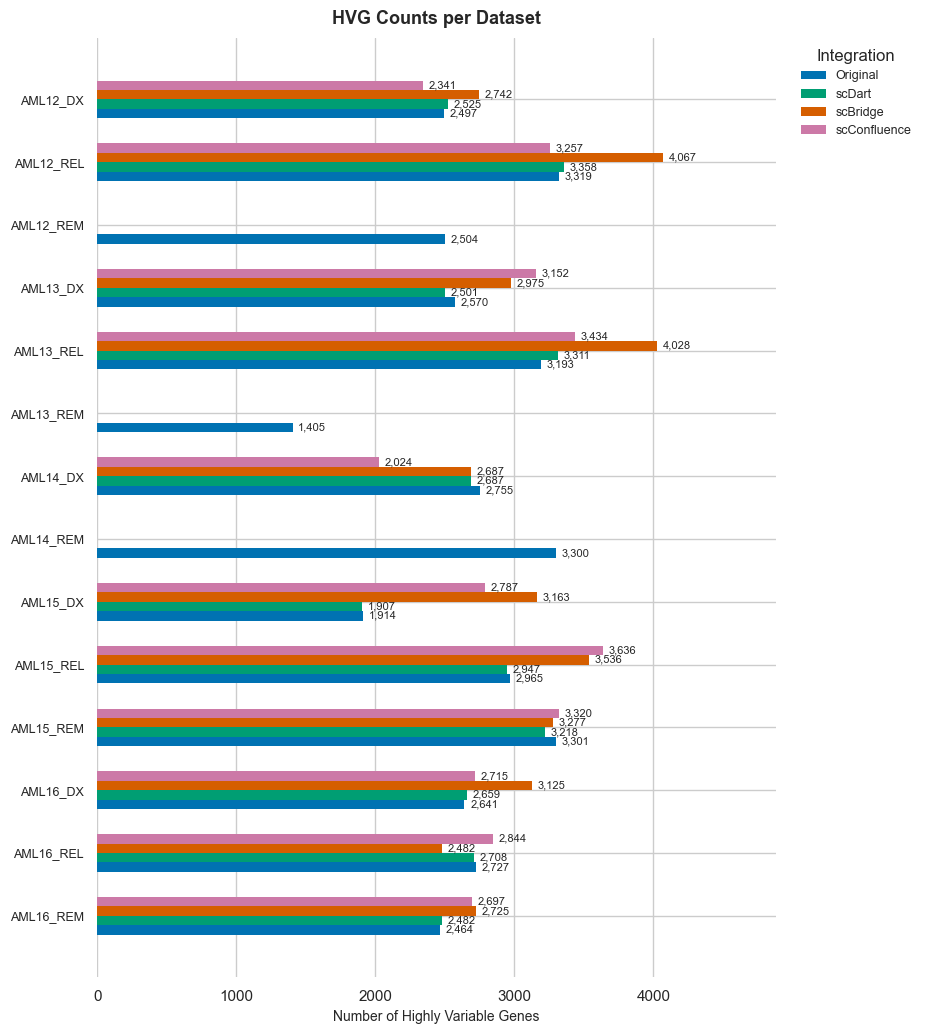

In [101]:
plot_grouped_hvg_bars(
    csv_path="../../results/rna_hvg_counts.csv",
    title="HVG Counts per Dataset")

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_qc_barplots(csv_path, tittle):
    """
    Reads a CSV file containing QC metrics and generates horizontal bar plots.
    
    If columns include:
      - 'n_rna_cells' and 'n_atac_cells': generates 4 plots (RNA, ATAC, total cells, fragments)
      - otherwise: generates 2 plots (total cells, fragments), with the fragments plot wider
    
    Bars are sorted alphabetically from top (A) to bottom (Z).
    """
    df = pd.read_csv(csv_path)
    df = df.sort_values(by="dataset", ascending=False)

    has_rna_atac = 'n_rna_cells' in df.columns and 'n_atac_cells' in df.columns

    if has_rna_atac:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(tittle, fontsize=16)

        axes[0, 0].barh(df['dataset'], df['n_rna_cells'], color='steelblue')
        axes[0, 0].set_title("Number of RNA Cells")
        axes[0, 0].set_xlabel("Cells")

        axes[0, 1].barh(df['dataset'], df['n_atac_cells'], color='darkorange')
        axes[0, 1].set_title("Number of ATAC Cells")
        axes[0, 1].set_xlabel("Cells")

        axes[1, 0].barh(df['dataset'], df['n_total_cells'], color='seagreen')
        axes[1, 0].set_title("Total Number of Cells")
        axes[1, 0].set_xlabel("Cells")

        axes[1, 1].barh(df['dataset'], df['n_fragments'], color='purple')
        axes[1, 1].set_title("Number of Fragments (ATAC)")
        axes[1, 1].set_xlabel("Fragments")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    else:
        # Custom grid for uneven width
        fig = plt.figure(figsize=(16, 6))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # Make fragments plot wider

        fig.suptitle(tittle, fontsize=16)

        ax0 = fig.add_subplot(gs[0])
        ax0.barh(df['dataset'], df['n_total_cells'], color='teal')
        ax0.set_title("Total Number of Cells")
        ax0.set_xlabel("Cells")

        ax1 = fig.add_subplot(gs[1])
        ax1.barh(df['dataset'], df['n_fragments'], color='indigo')
        ax1.set_title("Number of Fragments")
        ax1.set_xlabel("Fragments")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


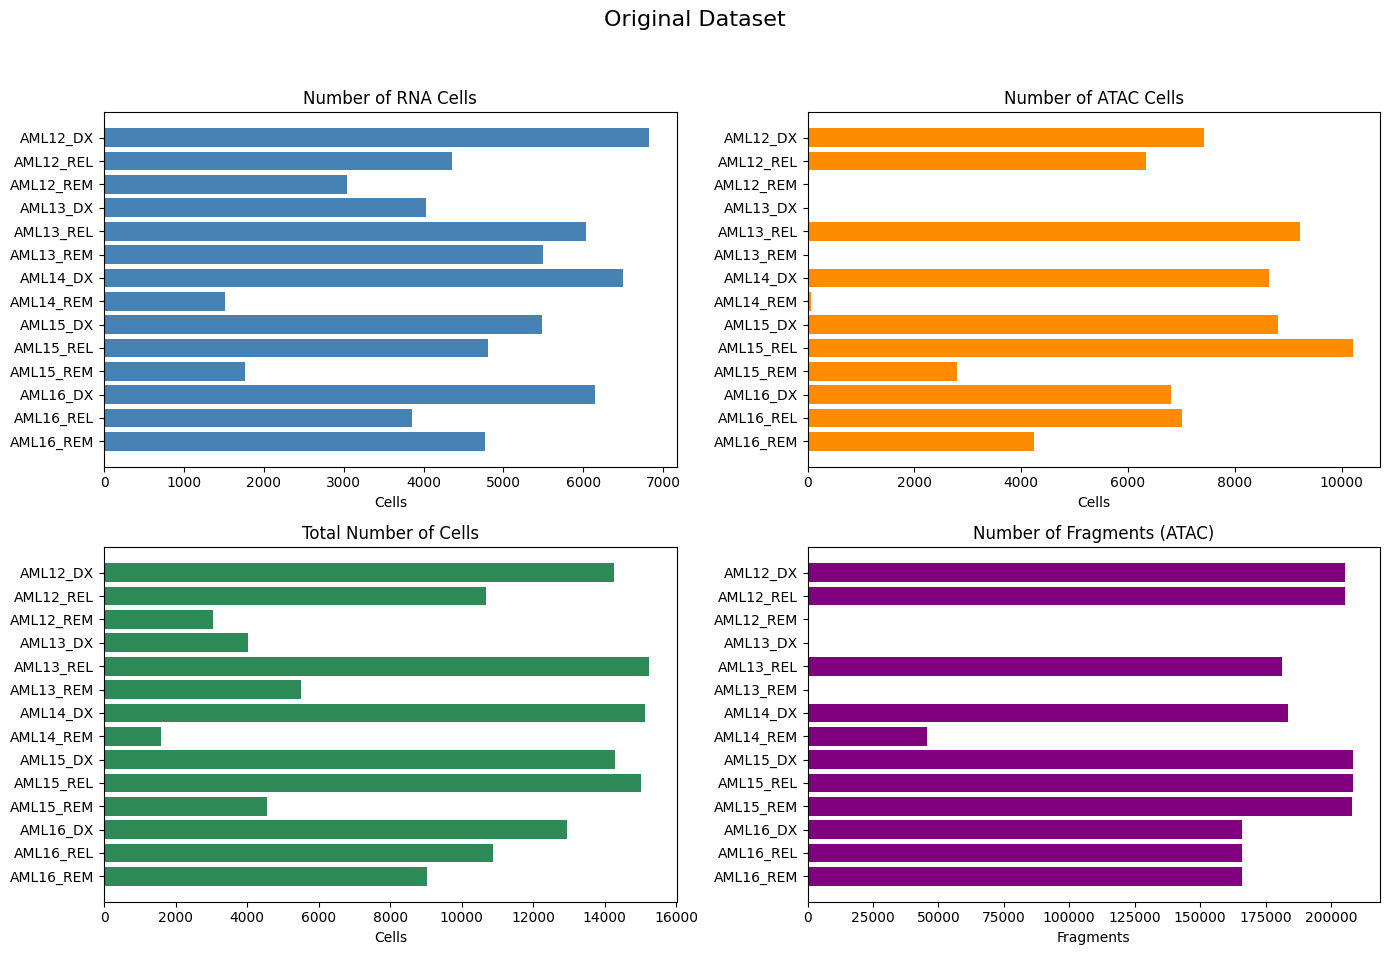

In [57]:
plot_qc_barplots("../../results/rna_atac_summary_no_mo.csv", "Original Dataset")

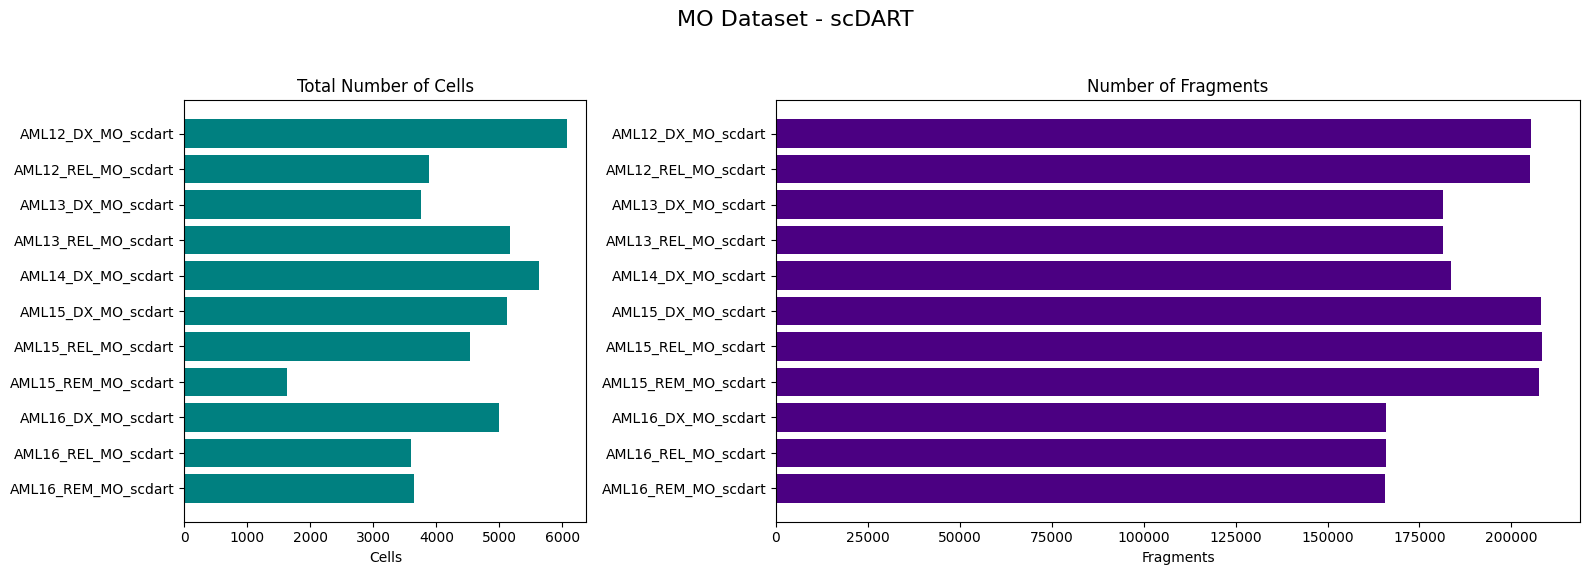

In [58]:
plot_qc_barplots("../../results/rna_atac_summary_mo_scdart.csv", "MO Dataset - scDART")

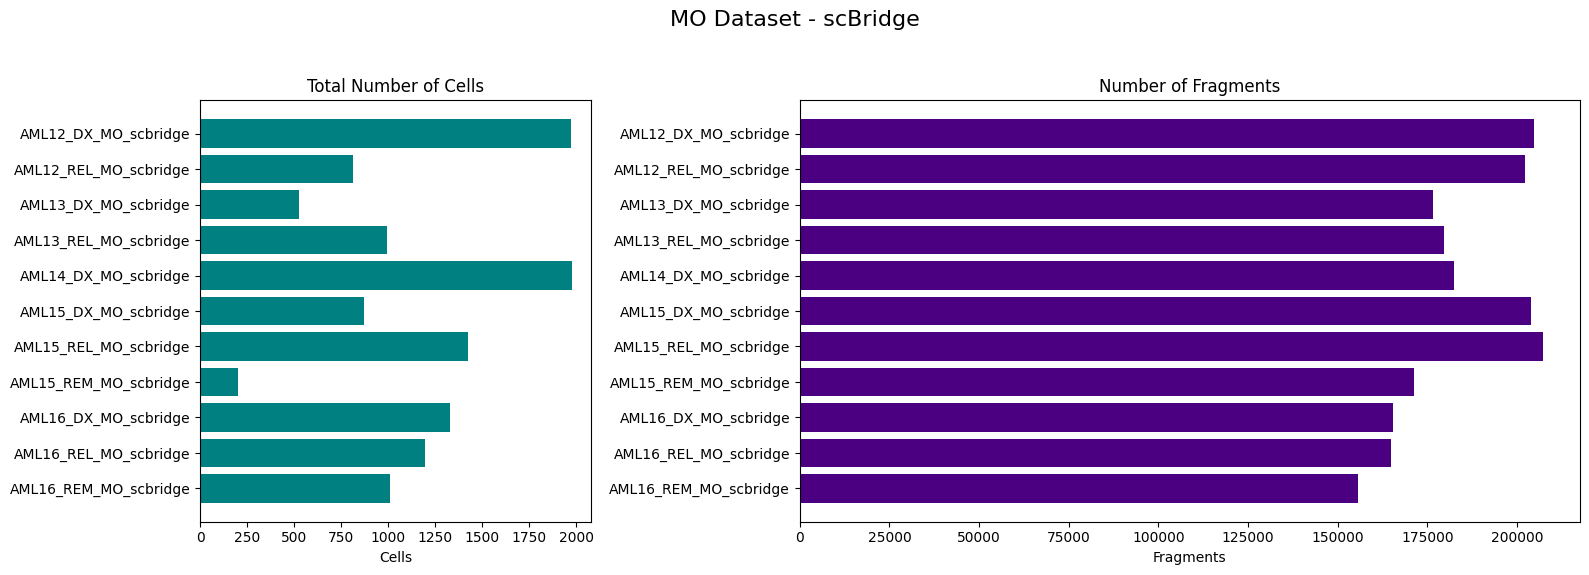

In [59]:
plot_qc_barplots("../../results/rna_atac_summary_mo_scbridge.csv", "MO Dataset - scBridge")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_total_cells_comparison(original_csv, mo_sources: dict, subtitle: str):
    """
    Creates a grouped horizontal bar plot comparing the total number of cells
    in the original dataset and multiple integrated versions.

    Parameters
    ----------
    original_csv : str
        Path to CSV with columns including 'dataset' and 'n_total_cells'

    mo_sources : dict
        Dictionary mapping integration method names (str) to their CSV paths (str).
        Example: {'scDART': 'scdart.csv', 'scBRIDE': 'scbride.csv', 'scConfluence': 'sccon.csv'}

    subtitle : str
        Subtitle for the plot (e.g., "Comparison of original vs integrated datasets")
    """
    # Use seaborn styling for a clean academic look
    sns.set(style="whitegrid")
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.title_fontsize": 11
    })

    # Define academic color palette (colorblind safe)
    palette = sns.color_palette("colorblind")
    source_names = ['Original'] + list(mo_sources.keys())
    source_colors = dict(zip(source_names, palette[:len(source_names)]))

    # Load and prepare original data
    orig = pd.read_csv(original_csv)
    orig = orig[['dataset', 'n_total_cells']].copy()
    orig = orig.dropna(subset=['n_total_cells'])
    orig['source'] = 'Original'
    orig['base_dataset'] = orig['dataset']

    # Load and process each integration method
    dfs = [orig]
    for method, path in mo_sources.items():
        df = pd.read_csv(path)
        df = df[['dataset', 'n_total_cells']].copy()
        df = df.dropna(subset=['n_total_cells'])
        df['source'] = method
        df['base_dataset'] = df['dataset'].str.extract(r'(^AML\d+_(?:DX|REL|REM))')[0]
        dfs.append(df)

    # Combine and prepare
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined.dropna(subset=['base_dataset'])
    combined['base_dataset'] = combined['base_dataset'].astype(str)
    combined = combined.sort_values(by='base_dataset', ascending=False)

    # Pivot to wide format
    pivot = combined.pivot_table(index='base_dataset', columns='source', values='n_total_cells')

    # Plotting
    fig, ax = plt.subplots(figsize=(11, 0.5 * len(pivot)))

    y_pos = range(len(pivot))
    bar_width = 0.15
    sources = pivot.columns.tolist()
    offsets = {
        i: (-bar_width * (len(sources)-1)/2 + i * bar_width)
        for i in range(len(sources))
    }

    for i, source in enumerate(sources):
        ax.barh(
            [y + offsets[i] for y in y_pos],
            pivot[source],
            height=bar_width,
            label=source,
            color=source_colors.get(source, "gray")
        )

    ax.set_yticks(list(y_pos))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Total Number of Cells")
    ax.set_title("Comparison of Total Cells per Sample", pad=10)
    ax.legend(loc='upper right', title="Data Source")
    ax.xaxis.grid(True, linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

    plt.suptitle(subtitle, fontsize=11, y=0.94)
    plt.tight_layout(rect=[0, 0.04, 1, 0.95])
    plt.show()


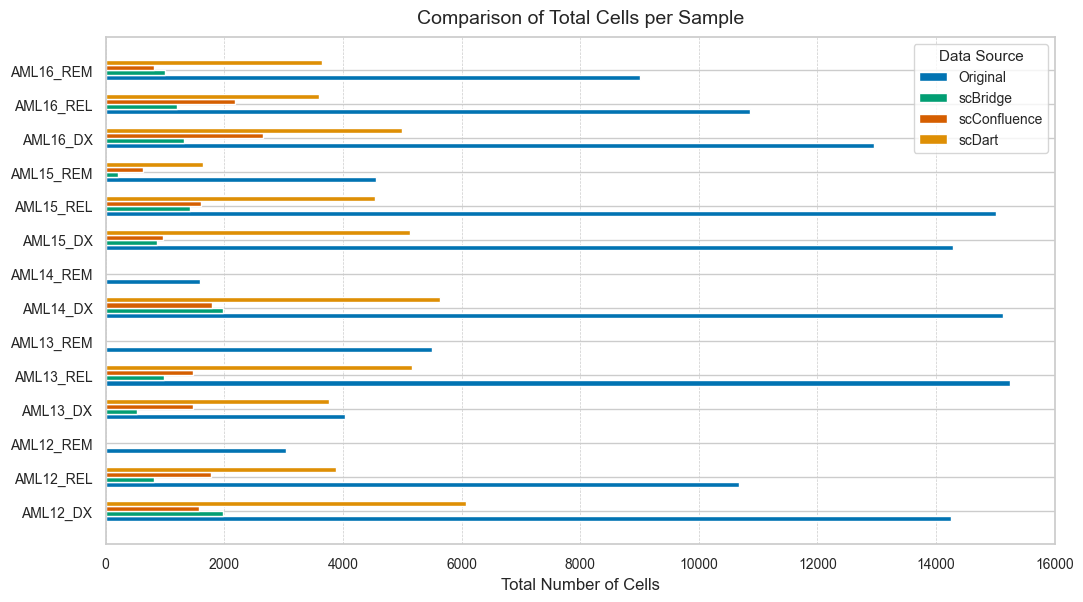

In [6]:
plot_total_cells_comparison(
    original_csv="../../results/rna_atac_summary_no_mo.csv",
    mo_sources={
        "scDart": "../../results/rna_atac_summary_mo_scdart.csv",
        "scBridge": "../../results/rna_atac_summary_mo_scbridge.csv",
        "scConfluence": "../../results/rna_atac_summary_mo_scconfluence.csv"
    },
    subtitle=""
)


In [ ]:
# Need to read those CSVs to preview the groups
#TODO

preview_group(no_mo, "Datasets without MO")
preview_group(mo_scdart, "MO_scdart Datasets")
preview_group(mo_scbridge, "MO_scbridge Datasets")
preview_group(mo_scconfluence, "MO_scconfluence Datasets")



Datasets without MO
| dataset   |   n_rna_cells |   n_genes | n_atac_cells   | n_fragments   |   n_total_cells |
|-----------|---------------|-----------|----------------|---------------|-----------------|
| AML12_DX  |          6826 |     33538 | 7425           | 205238        |           14251 |
| AML12_REL |          4355 |     33538 | 6328           | 205232        |           10683 |
| AML12_REM |          3042 |     33538 | <NA>           | <NA>          |            3042 |
| AML13_DX  |          4032 |     33538 | <NA>           | <NA>          |            4032 |
| AML13_REL |          6027 |     33538 | 9217           | 181380        |           15244 |
| AML13_REM |          5494 |     33538 | <NA>           | <NA>          |            5494 |
| AML14_DX  |          6492 |     33538 | 8630           | 183463        |           15122 |
| AML14_REM |          1514 |     33538 | 70             | 45663         |            1584 |
| AML15_DX  |          5486 |     33538 | 8805   

### 3.3.2 Plot

In [24]:
from scipy.stats import spearmanr
import numpy as np

def test_independence_between_size_and_score(x, y):
    """
    Tests whether there is a statistically significant relationship (positive or negative)
    between dataset size and score using Spearman rank correlation.

    Filters out any (x_i, y_i) pairs where either value is NaN.

    Hypotheses:
    H₀: There is no association between size and score.
    H₁: There is a monotonic association (positive or negative).

    Parameters
    ----------
    x : array-like
        Dataset sizes (e.g., total number of cells)
    y : array-like
        Corresponding scores

    Returns
    -------
    dict
        {
            'rho': float,         # Spearman correlation coefficient
            'p_value': float,     # p-value for the test
            'n': int,             # number of valid pairs
            'reject_null': bool,  # True if p < 0.05
            'direction': 'positive' | 'negative' | 'none'
        }
    """
    # Manually filter out NaNs by iterating through pairs
    x_clean = []
    y_clean = []
    for xi, yi in zip(x, y):
        if np.isfinite(xi) and np.isfinite(yi):
            x_clean.append(xi)
            y_clean.append(yi)

    if len(x_clean) < 2:
        return {
            'rho': np.nan,
            'p_value': np.nan,
            'n': len(x_clean),
            'reject_null': False,
            'direction': 'none'
        }

    rho, p = spearmanr(x_clean, y_clean)

    if np.isnan(rho):
        direction = 'none'
    elif rho > 0:
        direction = 'positive'
    elif rho < 0:
        direction = 'negative'
    else:
        direction = 'none'

    return {
        'rho': rho,
        'p_value': p,
        'n': len(x_clean),
        'reject_null': p < 0.05,
        'direction': direction
    }


In [21]:
grn_tools = ["scenicplus", "celloracle", "linger"]

config_parsers = {
    "scenicplus": scenicplus_config_parser,
    "celloracle": celloracle_config_parser,
    "linger": linger_config_parser,
}

benchmark_data = load_benchmark_data_with_parser(grn_tools, benchmark_dir, config_parsers, dataset_parser)


In [22]:
sizes = load_sizes_from_csvs([
    "../../results/rna_atac_summary_no_mo.csv",
    "../../results/rna_atac_summary_mo_scdart.csv",
    "../../results/rna_atac_summary_mo_scbridge.csv",
    "../../results/rna_atac_summary_mo_scconfluence.csv"
])

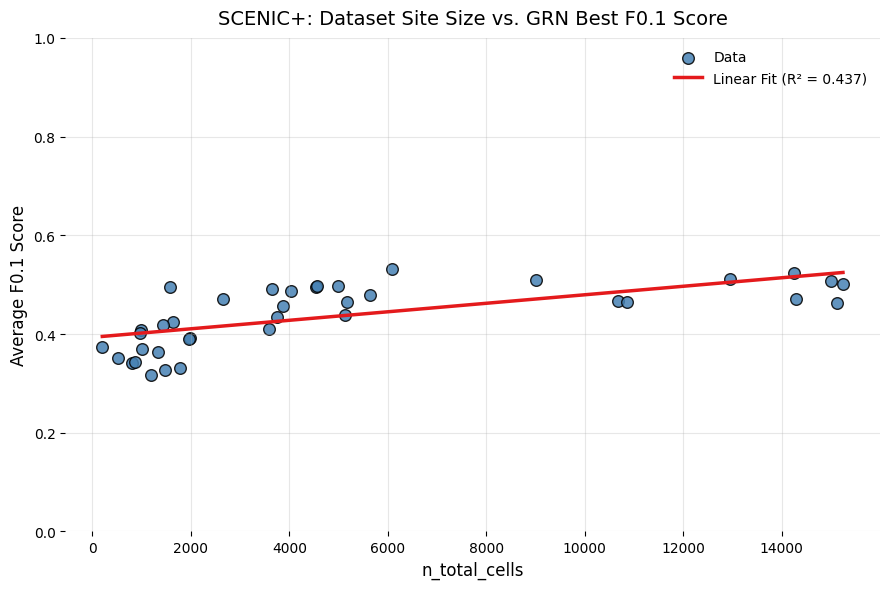

Spearman correlation: 0.786, p-value: 5.188e-09, n=38, reject null: True, direction: positive


In [35]:
tools = ["scenicplus"]
benchmark_data2 = merge_tools_by_dataset(benchmark_data, tools)
summary = summarize_dataset_averages(benchmark_data2, "best_fbeta")

x = []
for label in summary['y']:
    size = sizes.get(label, {})
    x.append(size.get("n_total_cells", np.nan))

# Now call the function
plot_scatter_with_regression(x, summary['x'], std=summary['std'], title="SCENIC+: Dataset Site Size vs. GRN Best F0.1 Score",)


test = test_independence_between_size_and_score(x, summary['x'])
print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


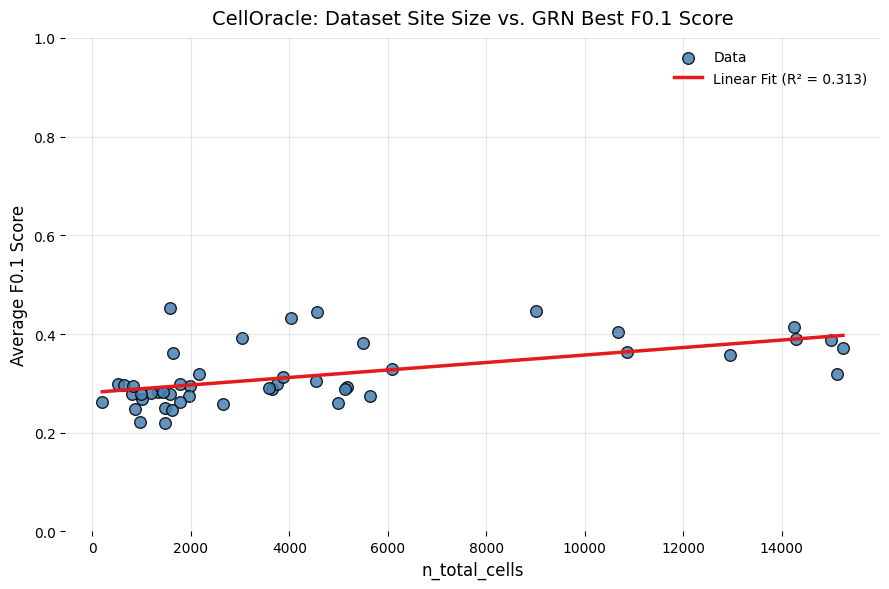

Spearman correlation: 0.589, p-value: 1.327e-05, n=47, reject null: True, direction: positive


In [36]:
tools = ["celloracle"]
benchmark_data2 = merge_tools_by_dataset(benchmark_data, tools)
summary = summarize_dataset_averages(benchmark_data2, "best_fbeta")

x = []
for label in summary['y']:
    size = sizes.get(label, {})
    x.append(size.get("n_total_cells", np.nan))

# Now call the function
plot_scatter_with_regression(x, summary['x'], std=summary['std'], title="CellOracle: Dataset Site Size vs. GRN Best F0.1 Score",)

test = test_independence_between_size_and_score(x, summary['x'])
print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


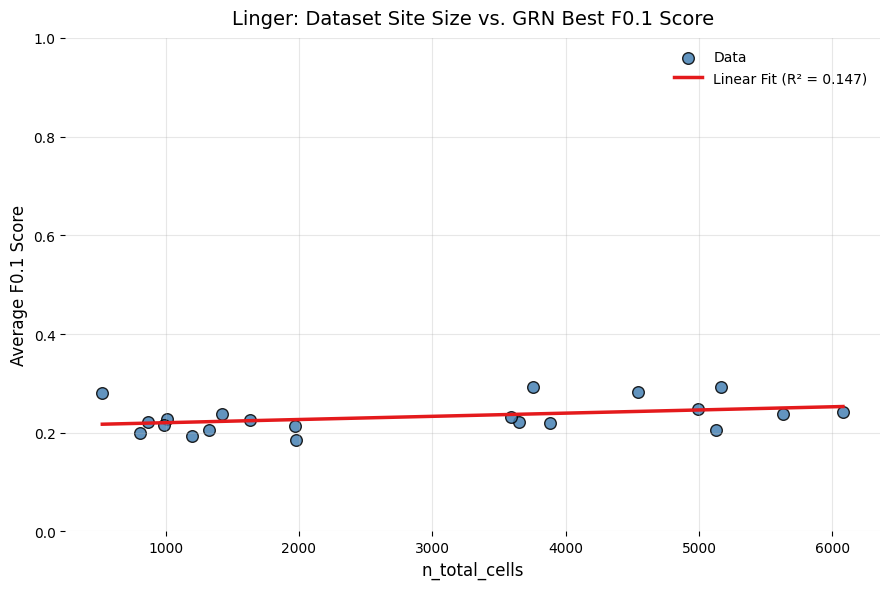

Spearman correlation: 0.394, p-value: 7.759e-02, n=21, reject null: False, direction: positive


In [37]:
tools = ["linger"]
benchmark_data2 = merge_tools_by_dataset(benchmark_data, tools)
summary = summarize_dataset_averages(benchmark_data2, "best_fbeta")

x = []
for label in summary['y']:
    size = sizes.get(label, {})
    x.append(size.get("n_total_cells", np.nan))

# Now call the function
plot_scatter_with_regression(x, summary['x'], std=summary['std'], title="Linger: Dataset Site Size vs. GRN Best F0.1 Score",)

test = test_independence_between_size_and_score(x, summary['x'])

print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")



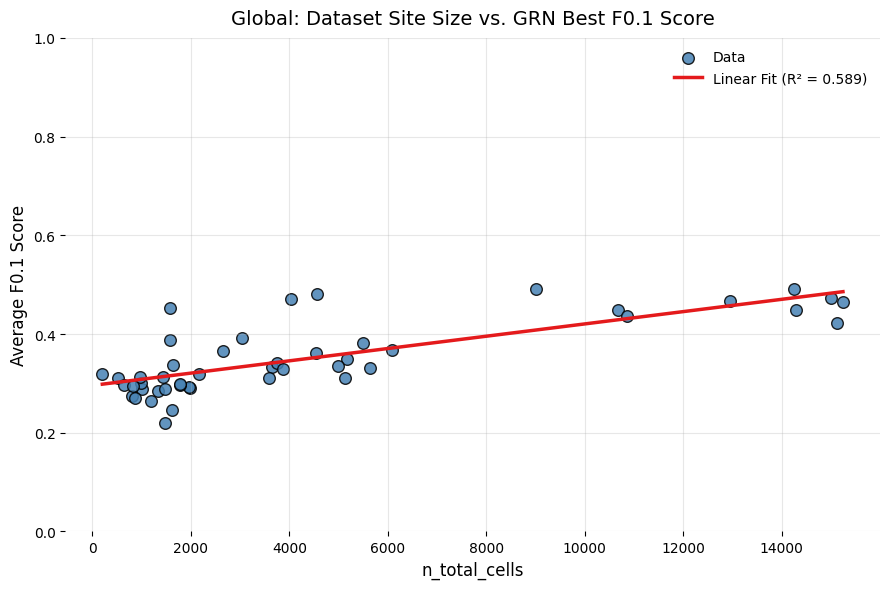

Spearman correlation: 0.752, p-value: 1.142e-09, n=47, reject null: True, direction: positive


In [38]:
tools = ["scenicplus", "celloracle", "linger"]
benchmark_data2 = merge_tools_by_dataset(benchmark_data, tools)
summary = summarize_dataset_averages(benchmark_data2, "best_fbeta")

x = []
for label in summary['y']:
    size = sizes.get(label, {})
    x.append(size.get("n_total_cells", np.nan))

# Now call the function
plot_scatter_with_regression(x, summary['x'], std=summary['std'], title="Global: Dataset Site Size vs. GRN Best F0.1 Score",)

test = test_independence_between_size_and_score(x, summary['x'])
print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


# 4. GRN Size and Score

## 4.1. Get GRN sizes

In [ ]:
# import os
# import pandas as pd
# import mudata

# def get_and_save_n_triplets(scenicplus_dir, celloracle_dir, out_dir,
#                             scenic_name="scplusmdata.h5mu", celloracle_name="mdata.h5mu"):
#     """
#     Efficiently extracts GRN triplet counts from SCENICPLUS and CellOracle .h5mu files,
#     only re-processing samples that haven't been saved yet.
#     """
#     os.makedirs(out_dir, exist_ok=True)
#     output_paths = {
#         "scenicplus": os.path.join(out_dir, "scenicplus.csv"),
#         "celloracle": os.path.join(out_dir, "celloracle.csv")
#     }

#     # Load previously saved records if available
#     existing = {}
#     for tool, out_path in output_paths.items():
#         if os.path.exists(out_path):
#             existing[tool] = pd.read_csv(out_path)
#         else:
#             existing[tool] = pd.DataFrame(columns=["sample", "n_triplets"])

#     records = {
#         "scenicplus": existing["scenicplus"].to_dict(orient="records"),
#         "celloracle": existing["celloracle"].to_dict(orient="records")
#     }
#     known_samples = {
#         "scenicplus": set(existing["scenicplus"]["sample"]),
#         "celloracle": set(existing["celloracle"]["sample"])
#     }

#     # SCENICPLUS
#     for sample in os.listdir(scenicplus_dir):
#         if sample in known_samples["scenicplus"]:
#             continue
#         path = os.path.join(scenicplus_dir, sample, scenic_name)
#         if os.path.exists(path):
#             try:
#                 mdata = mudata.read(path)
#                 direct_df = pd.DataFrame(mdata.uns['direct_e_regulon_metadata'])
#                 extended_df = pd.DataFrame(mdata.uns['extended_e_regulon_metadata'])
#                 grn = pd.concat([direct_df, extended_df], ignore_index=True)
#                 records["scenicplus"].append({"sample": sample, "n_triplets": grn.shape[0]})
#             except Exception as e:
#                 print(f"[WARN] Could not read SCENICPLUS file for {sample}: {e}")

#     # CellOracle
#     for sample in os.listdir(celloracle_dir):
#         if sample in known_samples["celloracle"]:
#             continue
#         path = os.path.join(celloracle_dir, sample, celloracle_name)
#         if os.path.exists(path):
#             try:
#                 mdata = mudata.read(path)
#                 grn = pd.DataFrame(mdata.uns['celloracle_links'])
#                 records["celloracle"].append({"sample": sample, "n_triplets": grn.shape[0]})
#             except Exception as e:
#                 print(f"[WARN] Could not read CellOracle file for {sample}: {e}")

#     # Save updated CSVs
#     for tool, recs in records.items():
#         df = pd.DataFrame(recs).drop_duplicates(subset="sample").sort_values("sample")
#         df.to_csv(output_paths[tool], index=False)


In [ ]:
# scenicplus_dir = "../../data/output/scenicplus/results"
# celloracle_dir = "../../data/output/celloracle/out"

# get_and_save_n_triplets(
#     scenicplus_dir=scenicplus_dir,
#     celloracle_dir=celloracle_dir,
#     out_dir="../../results",
#     scenic_name="scplusmdata.h5mu",
#     celloracle_name="mdata.h5mu"
# )

/home/andrem/miniconda3/envs/scenicplus2/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/andrem/miniconda3/envs/scenicplus2/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/andrem/miniconda3/envs/scenicplus2/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/andrem/miniconda3/envs/scenicplus2/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/andrem/miniconda3/envs/scenicplus2/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home

## 4.2. Load Data

In [18]:
import os
import pandas as pd

def load_flat_benchmark_data(grn_tools, benchmark_dir, sep="\t"):
    """
    Load benchmark result files into a flat dictionary:
    { "tool/filename": DataFrame }

    Parameters:
        grn_tools (list): List of tool names to load.
        benchmark_dir (str): Base directory containing tool folders.
        sep (str): Delimiter for reading the CSV files.

    Returns:
        dict: Flat benchmark data { "tool/filename": DataFrame }
    """
    flat_data = {}

    for tool in grn_tools:
        tool_dir = os.path.join(benchmark_dir, tool)
        if not os.path.isdir(tool_dir):
            print(f"[WARN] Skipping {tool}: directory not found.")
            continue

        for filename in os.listdir(tool_dir):
            if not filename.endswith("results.csv"):
                continue

            file_path = os.path.join(tool_dir, filename)
            try:
                df = pd.read_csv(file_path, sep=sep)
                flat_data[f"{filename}"] = df
            except Exception as e:
                print(f"[WARN] Skipping {tool}/{filename}: {e}")
    
    return flat_data


In [19]:
grn_tools = ["scenicplus", "celloracle", "linger"]


benchmark_data = load_flat_benchmark_data(grn_tools=grn_tools, benchmark_dir=benchmark_dir)


In [20]:
import numpy as np
import pandas as pd
from collections import defaultdict

def summarize_benchmark_results(flat_data_dict, metric=None):
    """
    Computes per-project averages over file-level benchmark rows.

    Parameters:
        flat_data_dict: dict of {filename: DataFrame}
        metric: optional str. If provided, averages only that column. Else all numeric values.

    Returns:
        dict with:
            - 'x': list of per-project means
            - 'y': list of project names
            - 'std': list of per-project std deviations
            - 'avrg_grn': project_name → list of file-level means
    """
    result = {
        'x': [],
        'y': [],
        'std': [],
        'avrg_grn': {}
    }

    grouped = defaultdict(list)

    for fname, df in flat_data_dict.items():
        df.columns = df.columns.str.strip()

        # Get the project name from the 'project_name' column
        if 'project_name' not in df.columns:
            print(f"[WARN] No project_name column in {fname}, skipping")
            continue

        project_names = df['project_name'].unique()
        if len(project_names) != 1:
            print(f"[WARN] Multiple or missing project_name values in {fname}, skipping")
            continue

        project = project_names[0]

        if metric is not None:
            if metric not in df.columns:
                print(f"[WARN] {metric} not in {fname}, skipping")
                continue
            values = df[metric].values
        else:
            values = df.select_dtypes(include=[np.number]).values.flatten()

        values = values[~np.isnan(values)]
        if values.size > 0:
            grouped[project].append(np.mean(values))
        else:
            print(f"[WARN] No valid numeric values in {fname}, skipping")

    for project, means in grouped.items():
        result['y'].append(project)
        result['x'].append(np.mean(means))
        result['std'].append(np.std(means))
        result['avrg_grn'][project] = means

    return result


In [21]:
import pandas as pd
import os

def load_triplet_counts(csv_paths):
    """
    Loads triplet counts from one or more CSV files with columns [sample, n_triplets].

    Parameters:
        csv_paths: list of str or str. Path(s) to CSV files.

    Returns:
        dict: {sample_label: n_triplets}
    """
    if isinstance(csv_paths, str):
        csv_paths = [csv_paths]

    triplet_dict = {}

    for path in csv_paths:
        try:
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip()

            if 'sample' not in df.columns or 'n_triplets' not in df.columns:
                print(f"[WARN] Missing required columns in {path}, skipping.")
                continue

            for _, row in df.iterrows():
                label = row['sample']
                count = row['n_triplets']
                triplet_dict[label] = int(count)

        except Exception as e:
            print(f"[ERROR] Could not read {path}: {e}")

    return triplet_dict


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import re

def detect_tool(filename):
    lower = filename.lower()
    if 'scenic' in lower:
        return 'scenic'
    elif 'celloracle' in lower:
        return 'celloracle'
    elif 'linger' in lower:
        return 'linger'
    return 'unknown'

def extract_label(sample_name, tool):
    if tool == 'linger':
        return sample_name

    if tool == 'scenic':
        mo_match = re.match(r'^(AML\d+_[A-Z]+)_MO_([a-zA-Z0-9]+)_metacell_(\d+)$', sample_name)
        non_mo_match = re.match(r'^(AML\d+_[A-Z]+)_metacell_(\d+)$', sample_name)

        if mo_match:
            patient_stage, tool_name, metacell = mo_match.groups()
            if metacell in {'0', '15'}:
                return f"{patient_stage}_MO_{tool_name}"
        elif non_mo_match:
            patient_stage, metacell = non_mo_match.groups()
            if metacell in {'0', '15'}:
                return patient_stage
        return None

    if tool == 'celloracle':
        mo_match = re.match(r'^(AML\d+_[A-Z]+)_MO_([a-zA-Z0-9]+)(?:_(with|without)_atac)?$', sample_name)
        if mo_match:
            patient_stage, tool_name, _ = mo_match.groups()
            return f"{patient_stage}_MO_{tool_name}"

        non_mo_match = re.match(r'^(AML\d+_[A-Z]+)(?:_(with|without)_atac)?$', sample_name)
        if non_mo_match:
            base, atac_flag = non_mo_match.groups()
            atac_label = atac_flag if atac_flag else "without"
            return f"{base}_{atac_label}_atac"

        return None

    return None

def custom_sort(labels, tool):
    if tool == 'celloracle':
        mo_labels = [l for l in labels if '_MO_' in l]
        non_mo_labels = [l for l in labels if '_MO_' not in l]

        with_atac = sorted([l for l in non_mo_labels if '_with_atac' in l])
        without_atac = sorted([l for l in non_mo_labels if '_without_atac' in l])

        mo_groups = {}
        for label in mo_labels:
            tool_name = label.split('_MO_')[-1]
            mo_groups.setdefault(tool_name, []).append(label)

        sorted_mo = []
        for tool_name in sorted(mo_groups.keys()):
            sorted_mo.extend(sorted(mo_groups[tool_name]))

        return without_atac + with_atac + sorted_mo

    else:
        non_mo = sorted([l for l in labels if '_MO_' not in l])
        mo = [l for l in labels if '_MO_' in l]

        mo_groups = {}
        for label in mo:
            tool_name = label.split('_MO_')[-1]
            mo_groups.setdefault(tool_name, []).append(label)

        sorted_mo = []
        for tool_name in sorted(mo_groups.keys()):
            sorted_mo.extend(sorted(mo_groups[tool_name]))

        return non_mo + sorted_mo

def plot_separate_bars(filename):
    df = pd.read_csv(filename)
    tool = detect_tool(filename)

    if tool == 'scenic':
        df = df[df['sample'].str.contains(r'metacell_(0|15)$')]

    df['Label'] = df['sample'].apply(lambda s: extract_label(s, tool))
    df = df[df['Label'].notnull()]

    if df.empty:
        raise ValueError(f"No valid samples matched for tool: {tool}. Check parsing rules or sample names.")

    df_grouped = df[['Label', 'n_triplets', 'n_tfs', 'n_genes']].set_index('Label')

    sorted_labels = custom_sort(df_grouped.index.tolist(), tool)
    df_grouped = df_grouped.loc[sorted_labels]  # NO reversal for vertical bars

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(max(8, len(df_grouped) * 0.5), 10), sharex=True)

    df_grouped['n_triplets'].plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Triplets')
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel('')

    df_grouped['n_tfs'].plot(kind='bar', ax=axes[1], color='darkorange')
    axes[1].set_title('Unique TFs')
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('')

    df_grouped['n_genes'].plot(kind='bar', ax=axes[2], color='seagreen')
    axes[2].set_title('Unique Genes')
    axes[2].set_ylabel('Count')
    axes[2].set_xlabel('Sample')
    axes[2].tick_params(axis='x', rotation=90)

    fig.suptitle(f'GRN Statistics per Sample [{tool.capitalize()}]', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



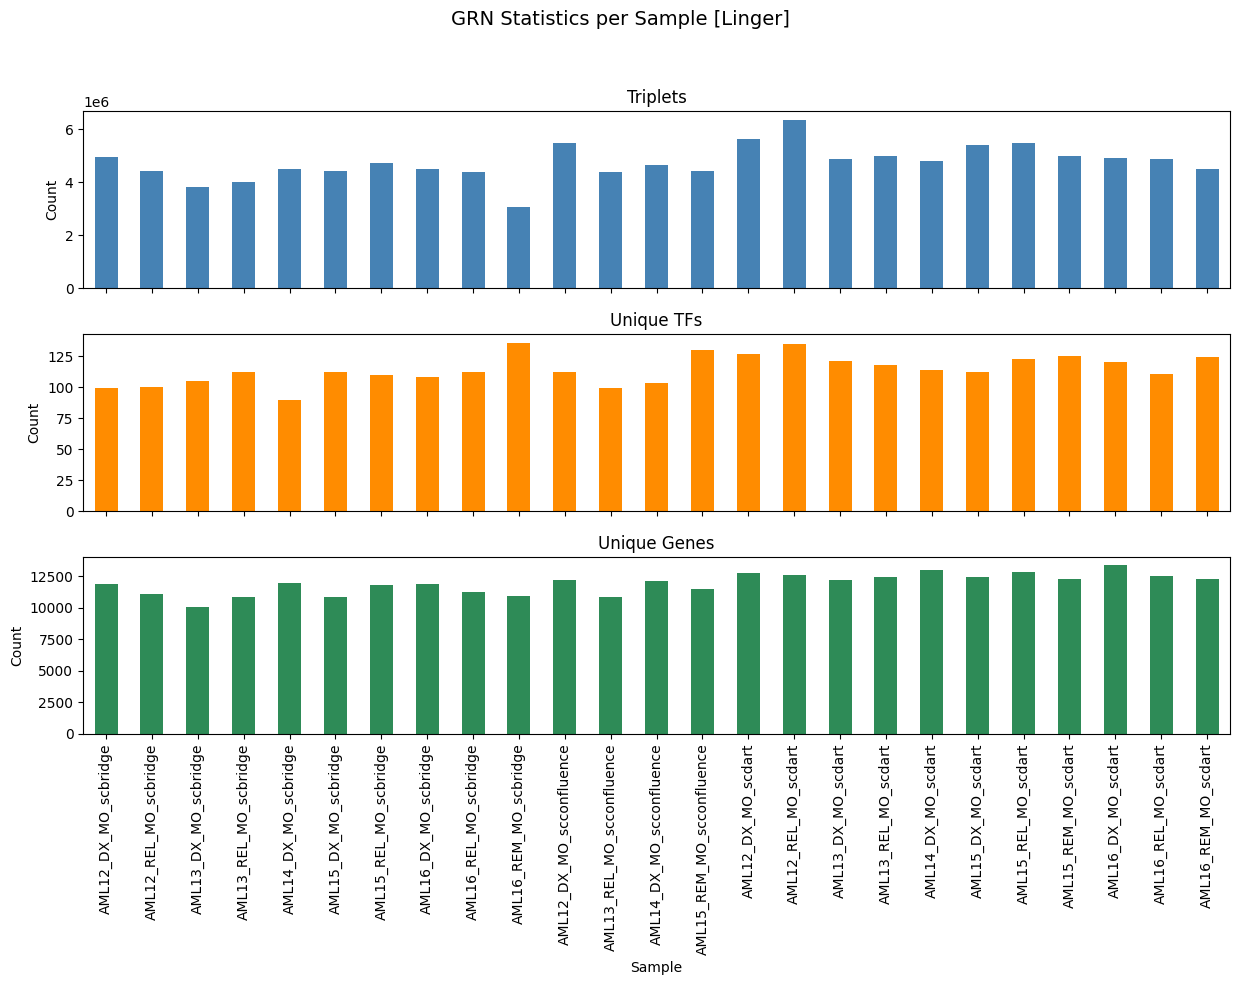

In [61]:
plot_separate_bars("../../results/linger.csv")

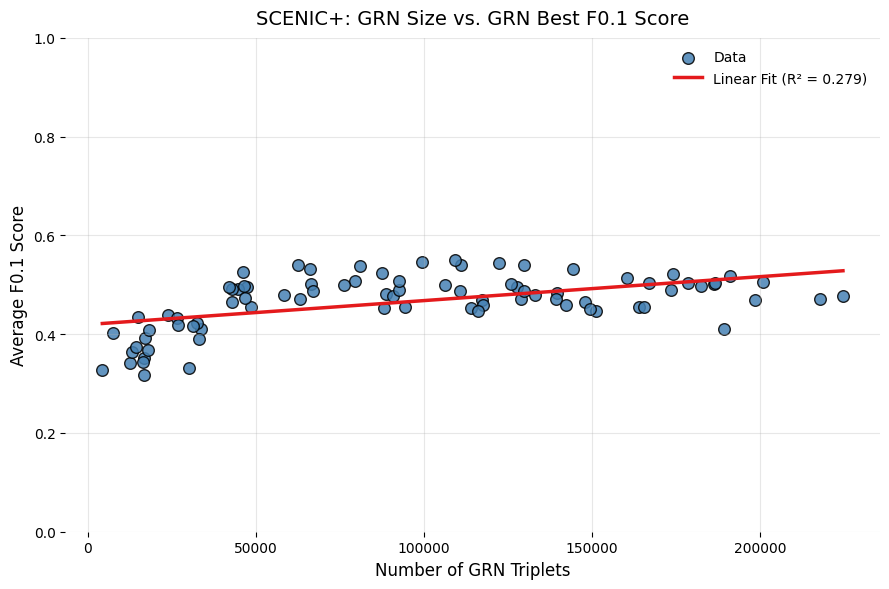

Spearman correlation: 0.495, p-value: 1.678e-06, n=84, reject null: True, direction: positive


In [25]:
summary = summarize_benchmark_results(benchmark_data, metric="best_fbeta")
triplet_count = load_triplet_counts("../../results/scenicplus.csv")

x = []
y = []
for label, value in zip(summary['y'], summary['x']):
    if label in triplet_count:
        x.append(triplet_count[label])
        y.append(value)

    

# Now call the function
plot_scatter_with_regression(x, y, xlabel="Number of GRN Triplets", title="SCENIC+: GRN Size vs. GRN Best F0.1 Score",)


test = test_independence_between_size_and_score(x, summary['x'])

print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


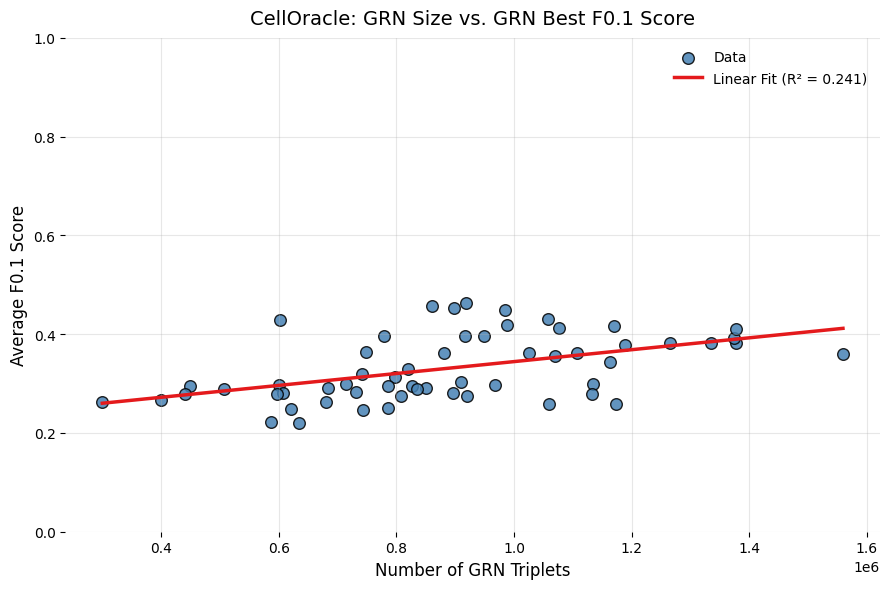

Spearman correlation: 0.507, p-value: 4.957e-05, n=58, reject null: True, direction: positive


In [26]:
summary = summarize_benchmark_results(benchmark_data, metric="best_fbeta")
triplet_count = load_triplet_counts("../../results/celloracle.csv")

x = []
y = []
for label, value in zip(summary['y'], summary['x']):
    if label in triplet_count:
        x.append(triplet_count[label])
        y.append(value)

    

# Now call the function
plot_scatter_with_regression(x, y, xlabel="Number of GRN Triplets", title="CellOracle: GRN Size vs. GRN Best F0.1 Score",)

test = test_independence_between_size_and_score(x, y)

print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


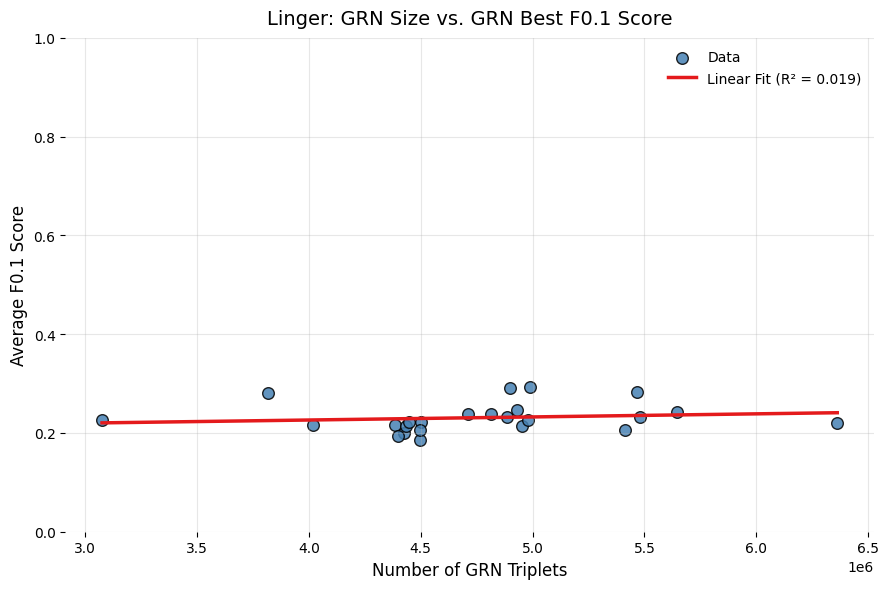

Spearman correlation: 0.333, p-value: 1.118e-01, n=24, reject null: False, direction: positive


In [29]:
summary = summarize_benchmark_results(benchmark_data, metric="best_fbeta")
triplet_count = load_triplet_counts("../../results/linger.csv")

x = []
y = []
for label, value in zip(summary['y'], summary['x']):
    if label in triplet_count:
        x.append(triplet_count[label])
        y.append(value)

# Now call the function
plot_scatter_with_regression(x, y, xlabel="Number of GRN Triplets", title="Linger: GRN Size vs. GRN Best F0.1 Score",)

test = test_independence_between_size_and_score(x, y)

print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


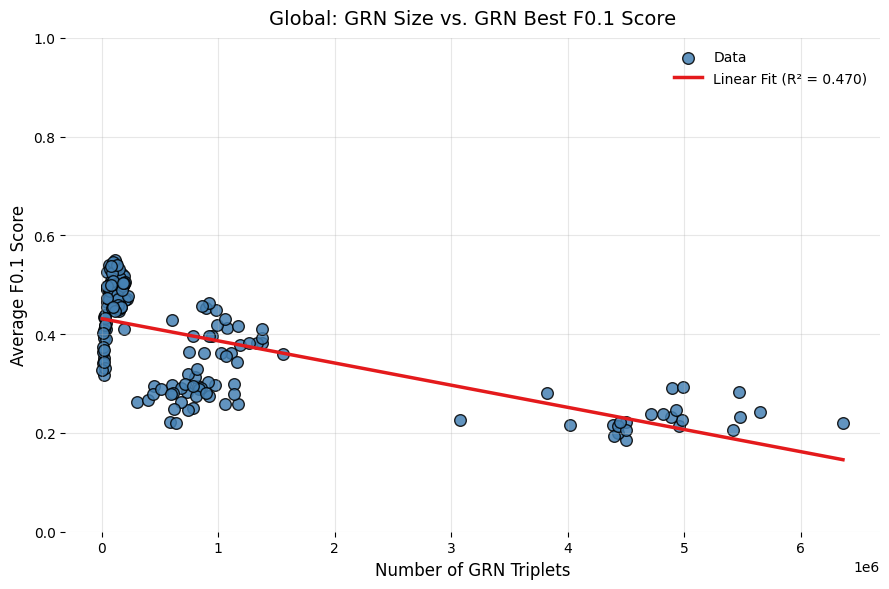

Spearman correlation: -0.630, p-value: 1.015e-19, n=166, reject null: True, direction: negative


In [30]:
summary = summarize_benchmark_results(benchmark_data, metric="best_fbeta")
triplet_count = load_triplet_counts(["../../results/celloracle.csv", "../../results/scenicplus.csv", "../../results/linger.csv"])

x = []
y = []
for label, value in zip(summary['y'], summary['x']):
    if label in triplet_count:
        x.append(triplet_count[label])
        y.append(value)

    

# Now call the function
plot_scatter_with_regression(x, y, xlabel="Number of GRN Triplets", title="Global: GRN Size vs. GRN Best F0.1 Score",)

test = test_independence_between_size_and_score(x, y)

print(f"Spearman correlation: {test['rho']:.3f}, p-value: {test['p_value']:.3e}, n={test['n']}, reject null: {test['reject_null']}, direction: {test['direction']}")


# 5. Threshold Cut Benchmark

## 5.1. Load Data

In [35]:
grn_tools = ["scenicplus", "celloracle", "linger"]

config_parsers = {
    "scenicplus": scenicplus_config_parser_pseudo,
    "celloracle": celloracle_config_parser,
    "linger": linger_config_parser,
}

benchmark_data = load_benchmark_data(grn_tools, benchmark_dir, config_parsers)


## 5.2. Plots

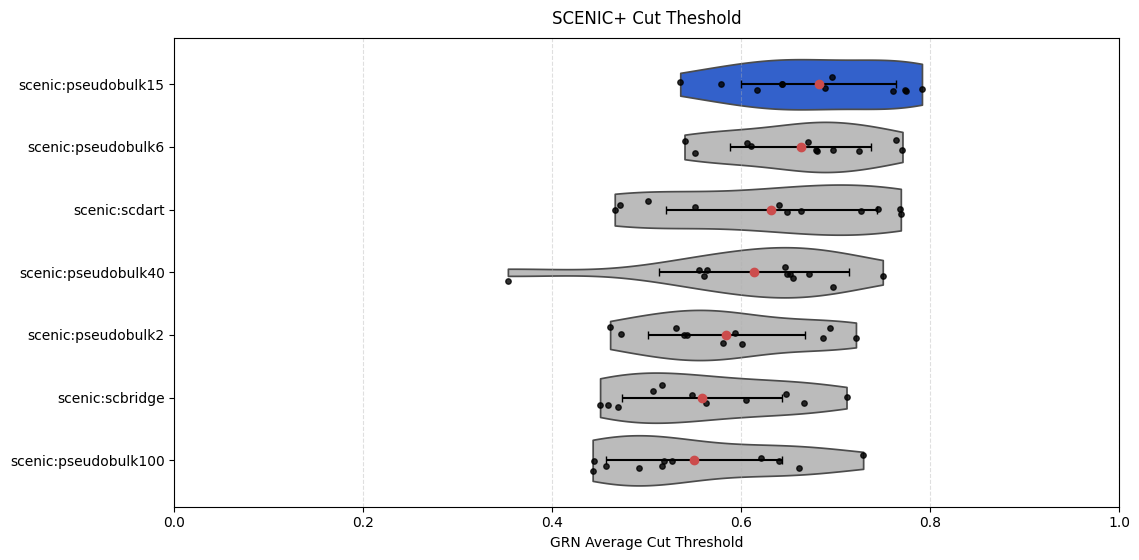

In [39]:
config_pairs = {
    "scenic:pseudobulk2": ("scenicplus", "pseudobulk:2"),
    "scenic:pseudobulk6": ("scenicplus", "pseudobulk:6"),
    "scenic:pseudobulk15": ("scenicplus", "pseudobulk:15"),
    "scenic:pseudobulk40": ("scenicplus", "pseudobulk:40"),
    "scenic:pseudobulk100": ("scenicplus", "pseudobulk:100"),
    "scenic:scdart": ("scenicplus", "scdart"),
    "scenic:scbridge": ("scenicplus", "scbridge"),
}

summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_threshold"])

title = "SCENIC+ Cut Theshold"
xlabel = "GRN Average Cut Threshold"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel, show_pvalues=False, xlim=(0, 1))

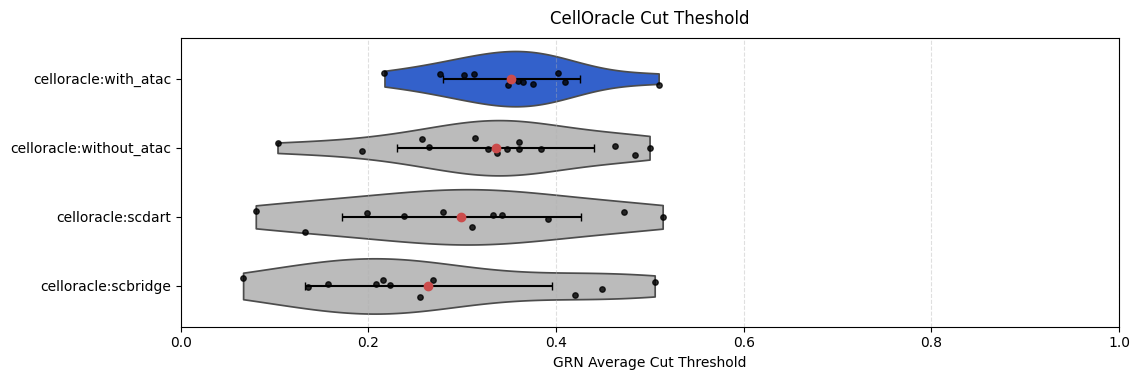

In [40]:
config_pairs = {
    "celloracle:with_atac": ("celloracle", "with_atac"),
    "celloracle:without_atac": ("celloracle", "without_atac"),
    "celloracle:scbridge": ("celloracle", "scbridge"),
    "celloracle:scdart": ("celloracle", "scdart")
}
summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_threshold"])

title = "CellOracle Cut Theshold"
xlabel = "GRN Average Cut Threshold"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel, show_pvalues=False, xlim=(0, 1))

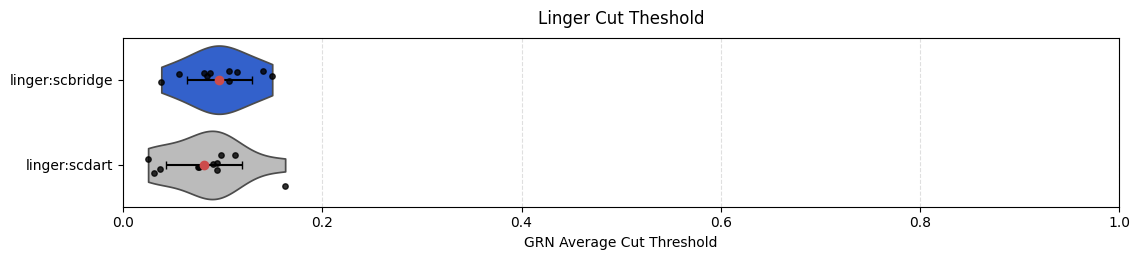

In [41]:
config_pairs = {
    "linger:scdart": ("linger", "scdart"),
    "linger:scbridge": ("linger", "scbridge")
}
summary = summarize_grn_performance(benchmark_data, config_pairs, metric_columns=["best_threshold"])

title = "Linger Cut Theshold"
xlabel = "GRN Average Cut Threshold"
ylabel = ""
plot_grn_violin(summary, title, xlabel, ylabel, show_pvalues=False, xlim=(0, 1))

# 6. Benchmark per metrics

## 6.1 Load Data

In [19]:
grn_tools = ["scenicplus", "celloracle", "linger"]

config_parsers = {
    "scenicplus": scenicplus_config_parser_pseudo,
    "celloracle": celloracle_config_parser,
    "linger": linger_config_parser,
}

benchmark_data = load_benchmark_data(grn_tools, benchmark_dir, config_parsers)



In [20]:
import pandas as pd
import numpy as np

def compute_average_fbeta_matrix(nested_data):
    # Dictionary to hold: {(tool+config): {metric: [fbeta values]}}
    results = {}

    for tool, configs in nested_data.items():
        for config, files in configs.items():
            tool_config_label = f"{tool}_{config}"
            if tool_config_label not in results:
                results[tool_config_label] = {}
            for df in files.values():
                for _, row in df.iterrows():
                    metric = row['benchmark_name']
                    fbeta = row.get('best_fbeta', np.nan)  # in case some rows don't have it
                    if pd.notna(fbeta):
                        results[tool_config_label].setdefault(metric, []).append(fbeta)

    # Compute averages
    matrix_data = {}
    for tool_config, metrics in results.items():
        matrix_data[tool_config] = {}
        for metric, values in metrics.items():
            if values:
                matrix_data[tool_config][metric] = np.mean(values)
            else:
                matrix_data[tool_config][metric] = np.nan

    # Create a matrix-like DataFrame
    result_df = pd.DataFrame.from_dict(matrix_data, orient='index')
    return result_df


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fbeta_heatmap(df, title, xlabel, ylabel,  figsize=(10, 6), cmap="YlGnBu", annot=True):
    """
    Plot a heatmap from a DataFrame of F-beta scores, ordering columns by average across all rows.

    Parameters:
        df (pd.DataFrame): DataFrame where rows are methods and columns are evaluation tasks.
        figsize (tuple): Size of the figure (width, height).
        cmap (str): Color map for the heatmap.
        annot (bool): Whether to annotate heatmap cells with their values.
    """
    # Compute column-wise average
    column_means = df.mean(axis=0)

    # Sort columns by average F-beta score (descending)
    sorted_columns = column_means.sort_values(ascending=False).index
    df_sorted = df[sorted_columns]

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(df_sorted, cmap=cmap, annot=annot, fmt=".3f", cbar_kws={'label': 'F-beta Score'})
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


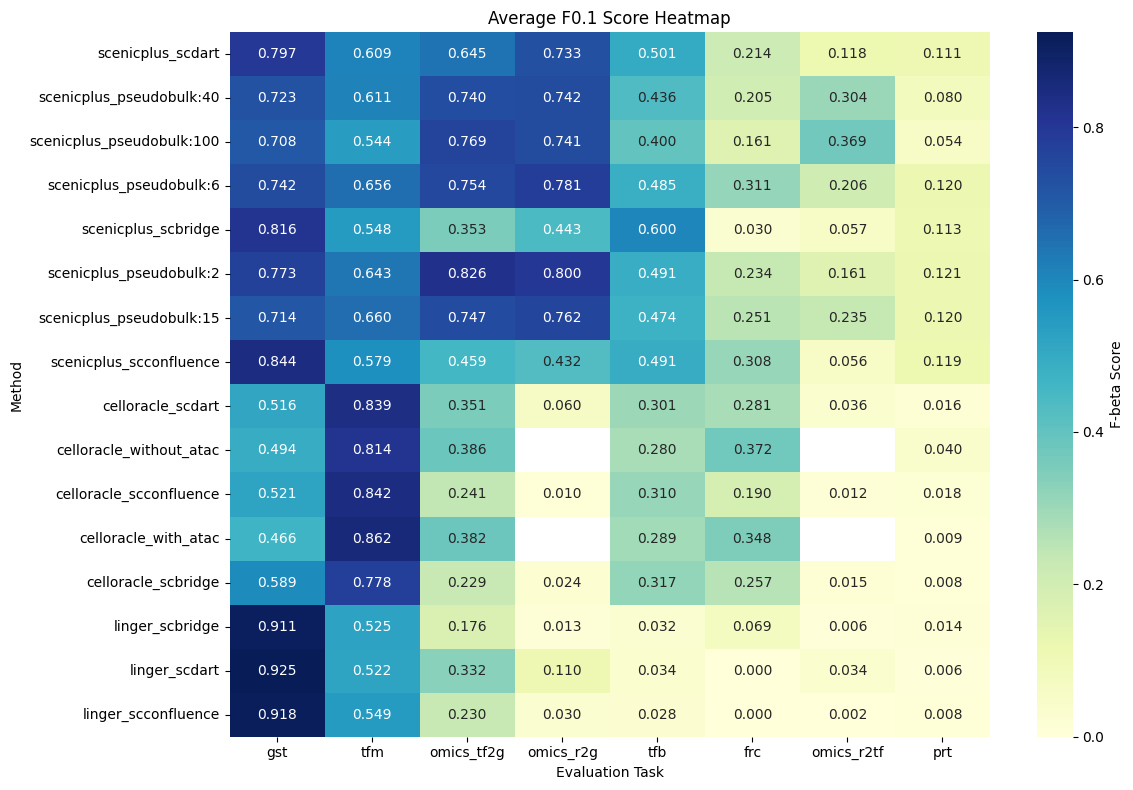

In [23]:
data = compute_average_fbeta_matrix(benchmark_data)

plot_fbeta_heatmap(data, title="Average F0.1 Score Heatmap", xlabel="Evaluation Task", ylabel="Method", figsize=(12, 8), cmap="YlGnBu", annot=True  )

# 7. Overlap